# Import libraries and define function

In [37]:
# reading files
import os
import rasterio
import geopandas as gpd
import pandas as pd

# process raster
import numpy as np
from scipy import signal
from dtaidistance import dtw
from scipy.interpolate import interp1d
from rasterio.features import geometry_mask
from rasterio.transform import from_origin
from rasterio.mask import mask

# visualizing files
import matplotlib.pyplot as plt
from rasterio.plot import show, show_hist
import contextily as cx

In [38]:
# define interpolation and extrapolation function for missing data in the timeseies due to cloud masking
def interpolate_and_extrapolate(array):
    '''
    This function is created with ChatGPT. It takes in array and perform linear interpolation and extrapolation on np.nan values
    '''
    
    # Find indices of non-NaN values
    x = np.arange(len(array))
    y = array.copy()
    valid_indices = ~np.isnan(y)

    # Create an interpolation function for valid values
    interp_func = interp1d(x[valid_indices], y[valid_indices], kind='linear', fill_value='extrapolate')

    # Interpolate/extrapolate the NaN values
    y[~valid_indices] = interp_func(x[~valid_indices])

    return y


In [39]:
# define NDVI calculation function
def NDVI_calculation(img, satellite):
    '''
    Takes in image and convert it to NDVI band
    '''
    # read NIR and red band
    if satellite == 'MODIS':    
        Red_band = img.read(1).astype('float64')
        NIR_band = img.read(2).astype('float64')
    elif satellite == 'Landsat 8':
        Red_band = img.read(4).astype('float64')
        NIR_band = img.read(5).astype('float64')

    # process no data value
    Red_band[Red_band == img.nodata] = np.nan
    NIR_band[NIR_band == img.nodata] = np.nan

    # calculate NDVI 
    NDVI_raster = (NIR_band - Red_band)/ (NIR_band + Red_band)
    
    return NDVI_raster

In [40]:
# define NDVI calculation function
def read_reflectance(img, satellite):
    '''
    Takes in image and convert it to NDVI band
    '''
    # read NIR and red band
    if satellite == 'MODIS':    
        Red_band = img.read(1).astype('float64')
        NIR_band = img.read(2).astype('float64')
    elif satellite == 'Landsat 8':
        Red_band = img.read(4).astype('float64')
        NIR_band = img.read(5).astype('float64')

    # process no data value
    Red_band[Red_band == img.nodata] = np.nan
    NIR_band[NIR_band == img.nodata] = np.nan

    
    return Red_band, NIR_band

In [41]:
### perform DTW distance and acquire new DTW distance raster

def DTW_raster(stacked_NDVI, ref_timeseries):

    # Create an empty result array with dimensions (180, 140)
    DTW_raster = np.empty((stacked_NDVI.shape[1], stacked_NDVI.shape[2]))

    # iterate through row and column  
    for row in np.arange(stacked_NDVI.shape[1]):
        for col in np.arange(stacked_NDVI.shape[2]):
            # store timeseries data in 
            timeseries = stacked_NDVI[:, row, col]

            # check if there are non nan value in timeseries
            if np.any((~np.isnan(timeseries))):
                
                # check if extrapolation or interpolation is neccessary
                if np.any(np.isnan(timeseries)):
                    timeseries = interpolate_and_extrapolate(timeseries)
                # SG filter
                timeseries_filter = signal.savgol_filter(timeseries, window_length=3, polyorder=2, mode="nearest")

                # perform DTW distance calculation

                DTW_value = dtw.distance(ref_timeseries, timeseries_filter)
                
            else:
                DTW_value = np.nan
            
            # input the dtw distance value back to the initialized array
            DTW_raster[row, col] = DTW_value
            
    return DTW_raster

In [42]:
def ref_coordinate(ref_img):
    '''
    Input clipped reference raster and generate coordinates of reference pixels
    '''
    # read band
    band = ref_img.read(1)

    # get coordinates from non nan value pixels
    band[band == ref_img.nodata] = np.nan
    non_nan_indices = np.where(~np.isnan(band)) # get row and column of non-nan pixels
    x_coords, y_coords = ref_img.xy(non_nan_indices[0], non_nan_indices[1])
    ref_coordinates = [(x, y) for x, y in zip(x_coords, y_coords)]

    return ref_coordinates


In [43]:
def ref_timeseries(ref_img, img, NDVI_stack):
    
    timeseries_list = []

    ref_coordinate_array = ref_coordinate(ref_img)

    # iterate through each coordinate
    for coordinate in ref_coordinate_array:
        row, col = img.index(coordinate[0], coordinate[1])
        indiv_timeseries = NDVI_stack[:, row, col]
        timeseries_list.append(indiv_timeseries)
    
    stacked_ref_timeseries = np.stack(timeseries_list, axis = 0)
    
    mean_ref_timeseries = np.nanmean(stacked_ref_timeseries, axis=0)

    return mean_ref_timeseries

-------------------------------------------------------

# Study Area

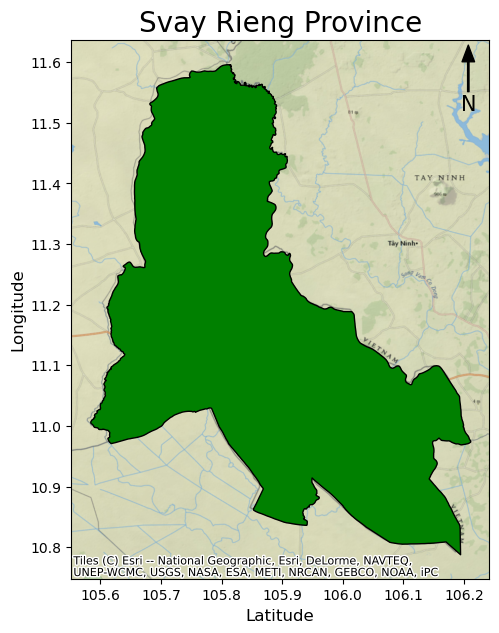

In [44]:
# read Svay Rieng boundary
study_boundary = gpd.read_file ('Svey Rieng Boundary\Svey_Rieng_Boundary.shx.shp')
study_boundary = study_boundary.to_crs(epsg=4326)

# plot Svay Rieng boundary
fig, ax = plt.subplots(figsize = (7,7))
study_boundary.plot(ax = ax, color = 'Green', edgecolor = 'k')

# aesthetics
ax.set_title(f'Svay Rieng Province', 
                fontsize = 20)
ax.set_xlabel('Latitude', fontsize = 12)
ax.set_ylabel('Longitude', fontsize = 12)

# add arrow
x, y, arrow_length = 0.95, 0.99, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# add base map
cx.add_basemap(ax, crs = study_boundary.crs.to_string(),
               source = cx.providers.Esri.NatGeoWorldMap)

------------------------------------------------------------------------------------

------------------------------------------------------------------------------------

------------------------------------------------------------------------------------

# MODIS: Load Images and process images

### MODIS Max Composite Threshold NDVI classification
- visualize max NDVI composite and max reflectance composite. 
- vary threshold of 0.45, 0.5, 0.55, 0.6, 0.65

In [45]:
### read max composite MODIS images 

# max reflectance composite
with rasterio.open('MODIS Max Composite Jan-Mar\MODIS Max Reflectance Composite-2017-01-01--2017-03-31.tif') as img:
    # read DN data
    Red_band = img.read(1).astype('float64') 
    NIR_band = img.read(2).astype('float64') 
    
    # process no data value
    Red_band[Red_band == img.nodata] = np.nan
    NIR_band[NIR_band == img.nodata] = np.nan

    # convert DN data into reflectance data
    Red_band = Red_band * 0.0001
    NIR_band = NIR_band * 0.0001

    # calculate NDVI
    reflectance_composite_NDVI = (NIR_band - Red_band)/ (NIR_band + Red_band)

    # store max reflectance profile and metadata
    reflectance_composite_profile = img.profile
    reflectance_composite_meta = img.meta
    
# max NDVI composite
with rasterio.open('MODIS Max Composite Jan-Mar\MODIS Max NDVI  Composite-2017-01-01--2017-03-31.tif') as img:
    # read NDVI composite NDVI data
    NDVI_composite_NDVI = img.read(1).astype('float64') 
    
    # process no data value
    NDVI_composite_NDVI[NDVI_composite_NDVI == img.nodata] = np.nan

    # store NDVI composite profile and metadata
    NDVI_composite_profile = img.profile
    NDVI_composite_meta = img.meta

C:\Users\varoc\AppData\Local\Temp\ipykernel_3456\3162080767.py:18: RuntimeWarning: invalid value encountered in divide
  reflectance_composite_NDVI = (NIR_band - Red_band)/ (NIR_band + Red_band)


In [46]:
# count the total number of pixels in the two provinces (exclude the white space nan)
MODIS_2pro_total_pixel = np.count_nonzero(~np.isnan(reflectance_composite_NDVI))

In [47]:
### specify MODIS threshold export condition
MODIS_threshold_export = True

In [48]:
### conduct thresholding selection

threshold_list = [0.45, 0.5, 0.55, 0.6, 0.65]
reflectance_composite_NDVI_dict = {}
NDVI_composite_NDVI_dict  = {}

# iterate through threshold list
for threshold in threshold_list:
    # temporarily store NDVI values
    reflectance_NDVI = reflectance_composite_NDVI.copy()
    NDVI_NDVI = NDVI_composite_NDVI.copy()

    # conduct thresholding
    reflectance_NDVI[reflectance_NDVI < threshold] = reflectance_composite_meta['nodata']
    NDVI_NDVI[NDVI_NDVI < threshold] = NDVI_composite_meta['nodata']

    # store threshold
    reflectance_composite_NDVI_dict[f'{threshold}'] = reflectance_NDVI
    NDVI_composite_NDVI_dict[f'{threshold}'] = NDVI_NDVI

    ### export to tif
    if MODIS_threshold_export == True:
        # prepare output directory
        output_folder = 'Processed tif - Remote Sensing Project'
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        MODIS_reflectance_Comp_threshold_name = f'MODIS Reflectance-{threshold} threshold NDVI.tif'
        MODIS_NDVI_Comp_threshold_name = f'MODIS NDVI-{threshold} threshold NDVI.tif'

        # prepare TRUE and nan file for visual clarity
        reflectance_non_nan_pixel = np.where(~np.isnan(reflectance_composite_NDVI_dict[f'{threshold}']), True, np.nan)
        NDVI_non_nan_pixel = np.where(~np.isnan(NDVI_composite_NDVI_dict[f'{threshold}']), True, np.nan)

        # update output tif data
        NDVI_composite_profile['nodata'] = np.nan
        NDVI_composite_profile['dtype'] = NDVI_non_nan_pixel.dtype

        # export reflectance composite tif
        with rasterio.open(os.path.join(output_folder, MODIS_reflectance_Comp_threshold_name), 'w', **NDVI_composite_profile) as dst:
            dst.write(reflectance_non_nan_pixel, 1)
        # export NDVI composite tif
        with rasterio.open(os.path.join(output_folder, MODIS_NDVI_Comp_threshold_name), 'w', **NDVI_composite_profile) as dst:
            dst.write(NDVI_non_nan_pixel, 1)

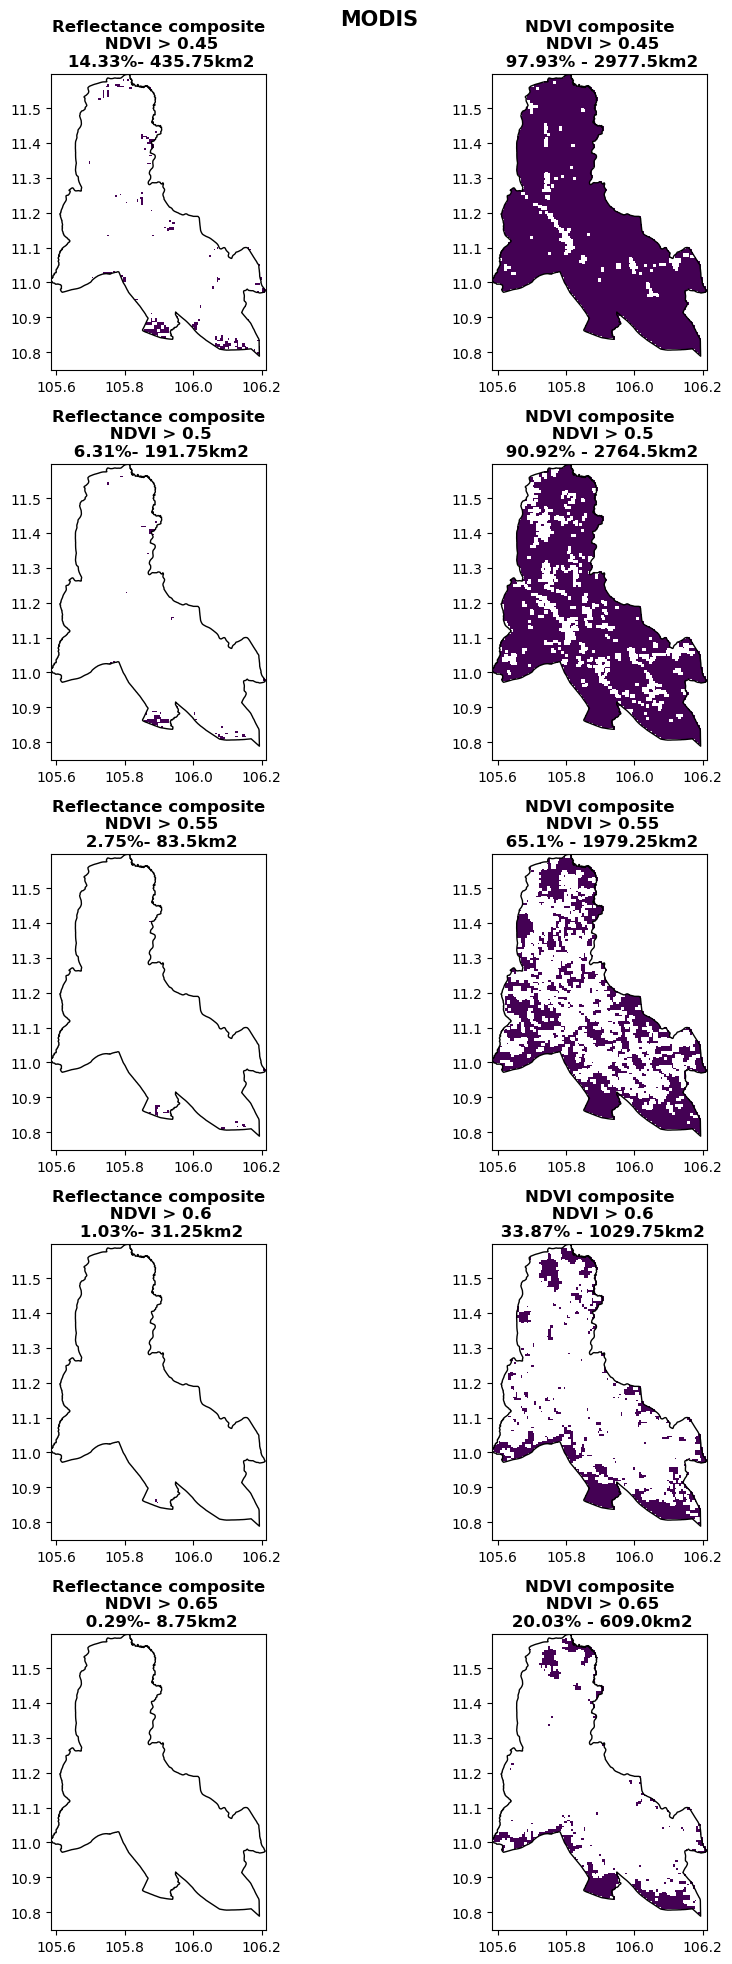

In [49]:
### plot thresholds

# read study boundary
study_boundary = gpd.read_file ('Svey Rieng Boundary\Svey_Rieng_Boundary.shx.shp')
study_boundary = study_boundary.to_crs(epsg=4326)

# plot
fig, ax = plt.subplots(len(threshold_list), 2 , figsize = (10, 20))

# iterate through threshold
for index, threshold in enumerate(threshold_list):
    
    ### plot for reflectance composite as True and nan (plot NDVI value blends in with background)
    # count non nan pixel and turn it into percent
    count_non_nan = np.count_nonzero(~np.isnan(reflectance_composite_NDVI_dict[f'{threshold}']))
    percent_pixel = round((count_non_nan/MODIS_2pro_total_pixel*100), 2)
    agri_area = (count_non_nan*500*500)/1000000
    # turn non nan pixel into True false
    reflectance_non_nan_pixel = np.where(~np.isnan(reflectance_composite_NDVI_dict[f'{threshold}']), True, np.nan)
    # plot map
    show(reflectance_non_nan_pixel, ax = ax[index, 0], 
         title= f'Reflectance composite\n NDVI > {threshold}\n {percent_pixel}%- {round(agri_area, 2)}km2', 
         transform = NDVI_composite_profile['transform'])

    ### plot for NDVI composite as True and nan (plot NDVI value blends in with background)
        # count non nan pixel and turn it into percent

    count_non_nan = np.count_nonzero(~np.isnan(NDVI_composite_NDVI_dict[f'{threshold}']))
    percent_pixel = round((count_non_nan/MODIS_2pro_total_pixel*100), 2)
    agri_area = (count_non_nan*500*500)/1000000
    # turn non nan pixel into True false
    NDVI_non_nan_pixel = np.where(~np.isnan(NDVI_composite_NDVI_dict[f'{threshold}']), True, np.nan)
    # plot map
    show(NDVI_non_nan_pixel, ax = ax[index, 1], 
         title= f'NDVI composite\n NDVI > {threshold}\n {percent_pixel}% - {round(agri_area, 2)}km2', 
         transform = NDVI_composite_profile['transform'])

    # add study boundary
    study_boundary.plot(ax = ax[index, 0], edgecolor = 'k', facecolor = 'none')
    study_boundary.plot(ax = ax[index, 1], edgecolor = 'k', facecolor = 'none')

plt.suptitle('MODIS', fontsize = 15, weight = 'bold')

plt.tight_layout()

Conclusion:

The NDVI Composite makes the most sense hence we will use the NDVI composite. The most sensible is the 0.55 threshold conducted by Erban and Gorelick (2016).


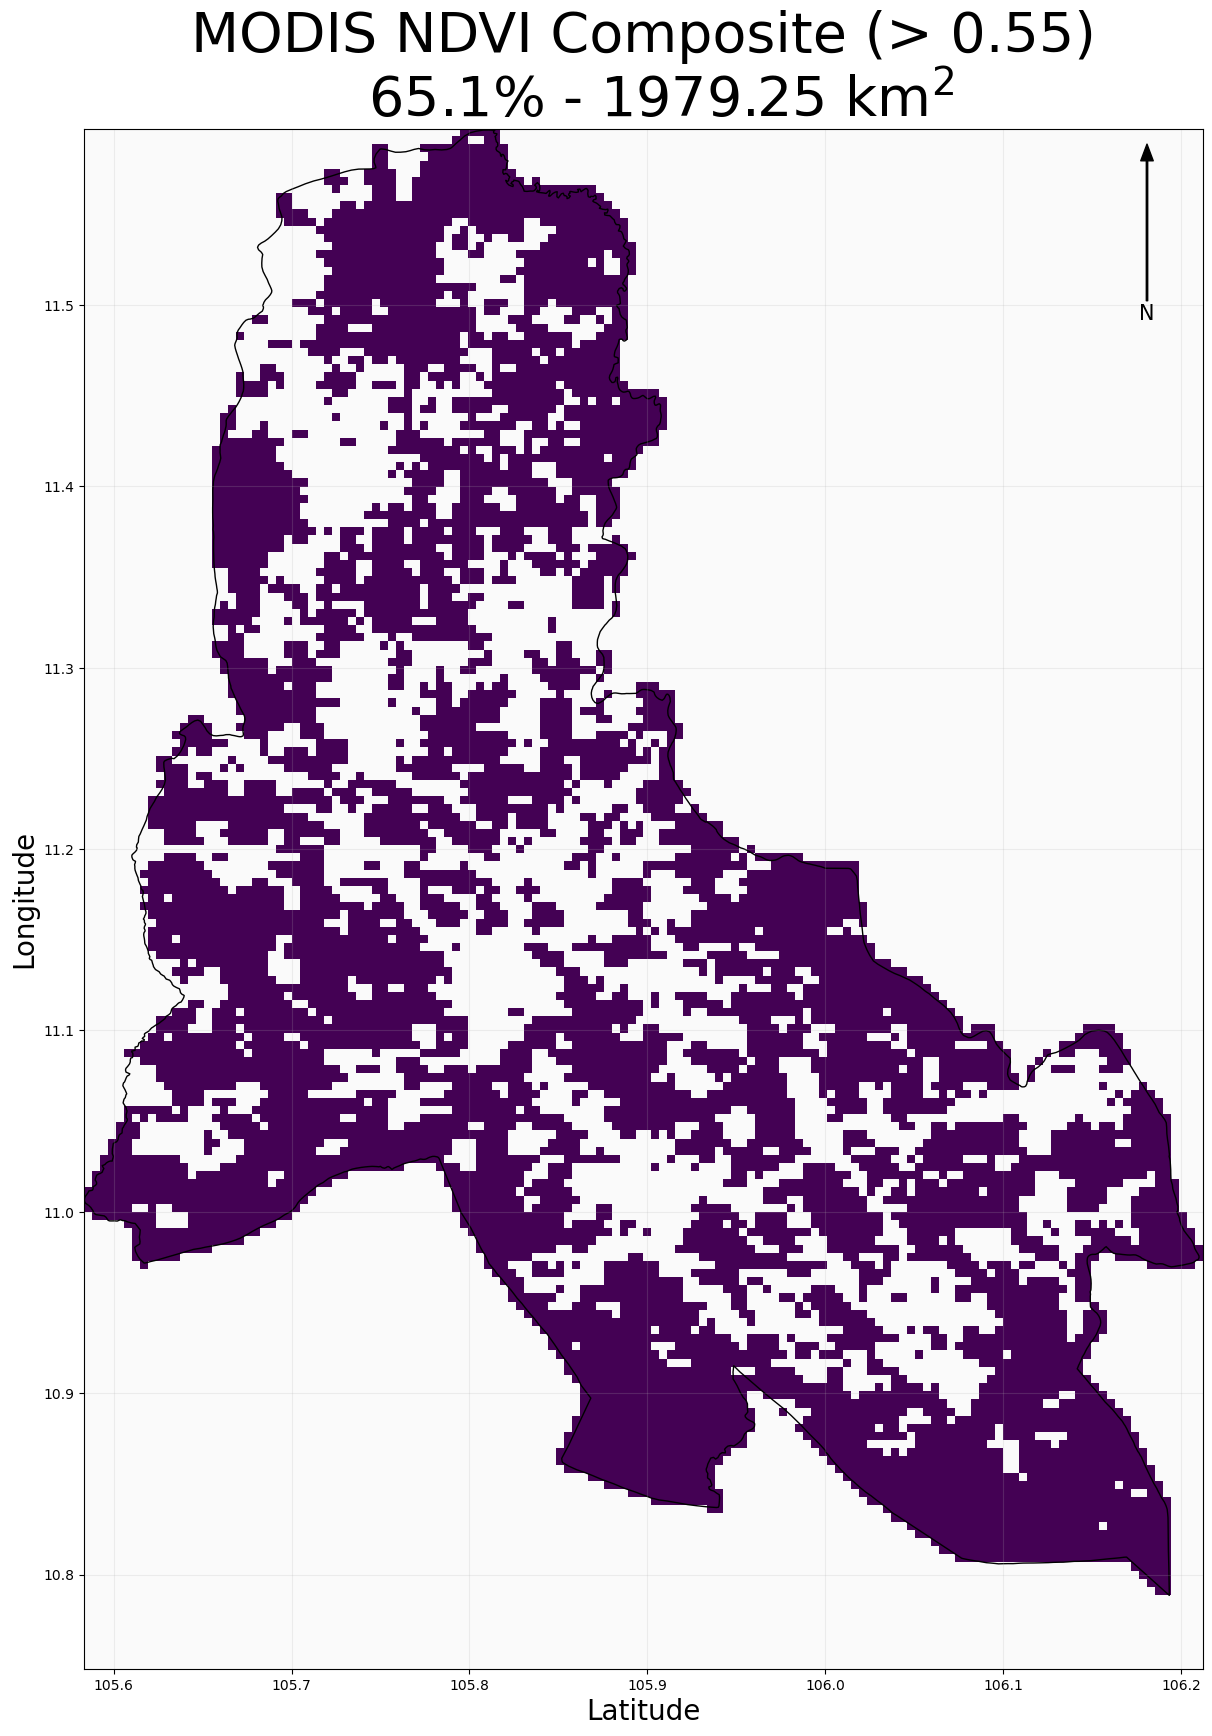

In [110]:
### plot 0.55 threshold of ndvi composite

# get Geotiff file name and read study boundary
MODIS_file = 'Processed tif - Remote Sensing Project\MODIS NDVI-0.55 threshold NDVI.tif'

# plot
fig, ax = plt.subplots(figsize=(20, 20))
with rasterio.open(MODIS_file) as MODIS_visual:
    show(MODIS_visual, ax = ax, transform = NDVI_composite_profile['transform'])
    MODIS_visual_raster = MODIS_visual.read(1)
    count_non_nan = np.count_nonzero(~np.isnan(MODIS_visual_raster))
    percent_pixel = round((count_non_nan/MODIS_2pro_total_pixel*100), 2)
    agri_area = (count_non_nan*500*500)/1000000


# aesthetics
ax.set_title(f'MODIS NDVI Composite (> 0.55)\n  {percent_pixel}% - {round(agri_area, 2)} km$^2$', 
                fontsize = 40)
ax.set_xlabel('Latitude', fontsize = 20)
ax.set_ylabel('Longitude', fontsize = 20)

# add arrow
x, y, arrow_length = 0.95, 0.99, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# add grid line
ax.grid(alpha = 0.2)

# add Svay Rieng Boundary 
study_boundary.plot(ax = ax, edgecolor = 'k', facecolor = 'none')


# Set the background color with alpha (transparency)
background_color = 'lightgray'  # You can change 'lightgray' to any color you prefer
alpha = 0.1  # You can adjust the alpha value as needed

ax.set_facecolor(background_color)
ax.patch.set_alpha(alpha)

---------------------------------------------------------------------------

### MODIS DTW distance time series classification

In [9]:
### extract coordinate from shapefile

# open raster
sample_raster = 'MODIS 2016-2017 Dry Season Monthly Mean Composite\MODIS Composite-2016-11-01--2016-11-30.tif'
with rasterio.open(sample_raster) as img:
    # get MODIS reference shapefile
    MODIS_ref_gdf = gpd.read_file('Reference Raster\MODIS Agriculture Polygon.shp')

    # initialize variable to store MODIS pixel corresponding to shape file
    combined_mask = np.zeros(img.shape, dtype=bool)
    # iterate through every polygon in shape file and store cooresponding MODIS pixel mask in combined_mask
    for index, row in MODIS_ref_gdf.iterrows():
        geom = row['geometry']
        mask = geometry_mask([geom], out_shape=img.shape, transform=img.transform, all_touched= True, invert=True)
        combined_mask |= mask

    # get profile for later plots
    MODIS_meanComposite_profile = img.profile

# turn False values into nan and True value into 1
combined_mask = combined_mask.astype(float)  # Convert the mask to a float type
combined_mask[combined_mask == 0] = np.nan

In [16]:
# prepare to read images

folder = 'MODIS 2016-2017 Dry Season Monthly Mean Composite'
filenames = [file for file in os.listdir(folder) if file.endswith('.tif')]

image_data_list = []

# iterate through every images in the study period
for filename in filenames:    
        # read image file
        path = os.path.join(folder, filename)
        with rasterio.open(path) as img:
            
            # calculate NDVI 
            NDVI_raster = NDVI_calculation(img, "MODIS")

            # store NDVI value in list
            image_data_list.append(NDVI_raster)

# stack the NDVI values to create [time, row, column] 3D array
stacked_NDVI_MODIS = np.stack(image_data_list, axis = 0)

# perform SG filter
for row in np.arange(stacked_NDVI_MODIS.shape[1]):
      for col in np.arange(stacked_NDVI_MODIS.shape[2]):
            current_pixel_timeseries = stacked_NDVI_MODIS[:, row, col]
            stacked_NDVI_MODIS[:, row, col] = signal.savgol_filter(current_pixel_timeseries, window_length=4, polyorder=3, mode="nearest")


<Axes: title={'center': 'MODIS Reference Pixels: 534.0 pixels'}, xlabel='Longitude', ylabel='Latitude'>

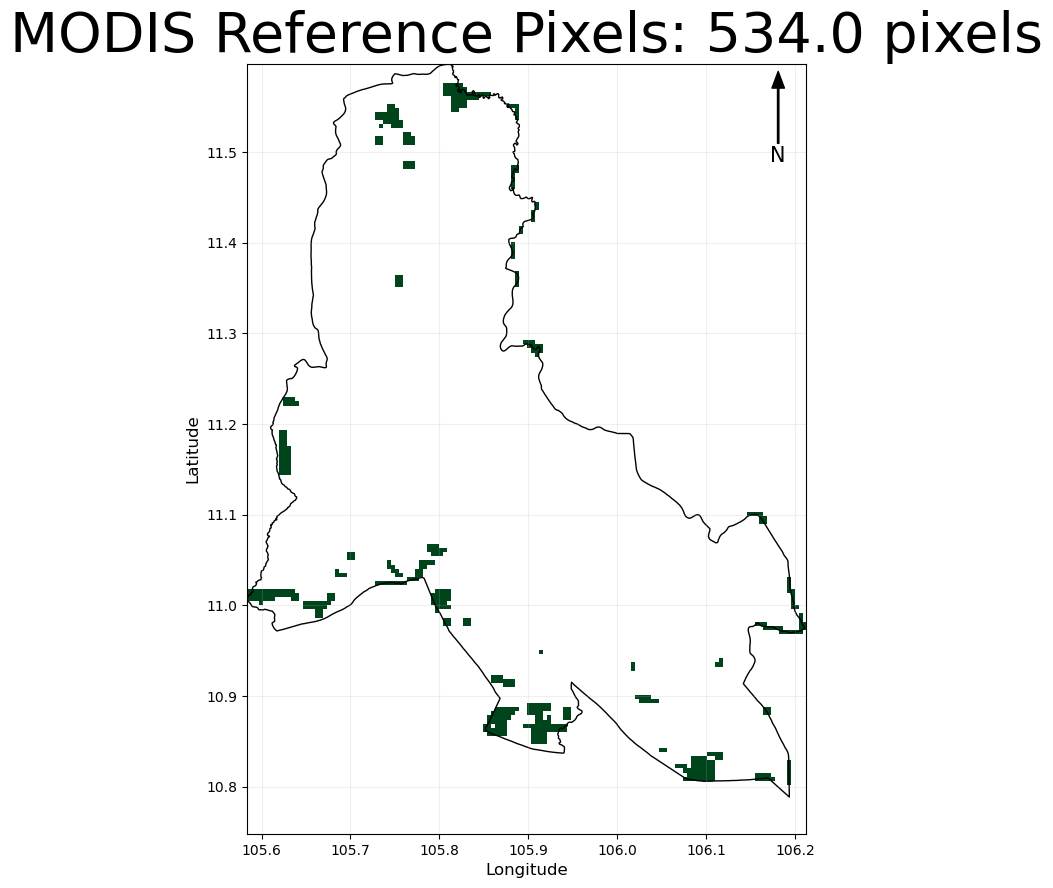

In [11]:
### plot MODIS reference pixel
fig, ax = plt.subplots(figsize = (10,10))
show(combined_mask, ax = ax, transform=MODIS_meanComposite_profile['transform'], cmap = 'Greens_r')

# aesthetics
ax.set_xlabel('Longitude', fontsize = 12)
ax.set_ylabel('Latitude', fontsize = 12)
ax.set_title( f'MODIS Reference Pixels: {np.nansum(combined_mask)} pixels', fontsize = 40)
# add arrow
x, y, arrow_length = 0.95, 0.99, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# add grid line
ax.grid(alpha = 0.2)

# add Svay Rieng Boundary 
study_boundary.plot(ax = ax, edgecolor = 'k', facecolor = 'none')

In [12]:
### get reference timeseries 

# duplicate "one time" combined_mask stack to match the "time" of the stacked_NDVI_MODIS 
stacked_combined_mask = np.tile(combined_mask, (stacked_NDVI_MODIS.shape[0], 1, 1))

# select only reference pixel
stacked_reference_MODIS_timeseries = stacked_combined_mask * stacked_NDVI_MODIS

# get reference NDVI timeseries
reference_MODIS_NDVI_timeseries = np.nanmean(stacked_reference_MODIS_timeseries, axis=(1,2))

<Axes: title={'center': 'MODIS Mean Composite DTW Threshold of 3.4'}, xlabel='Longitude', ylabel='Latitude'>

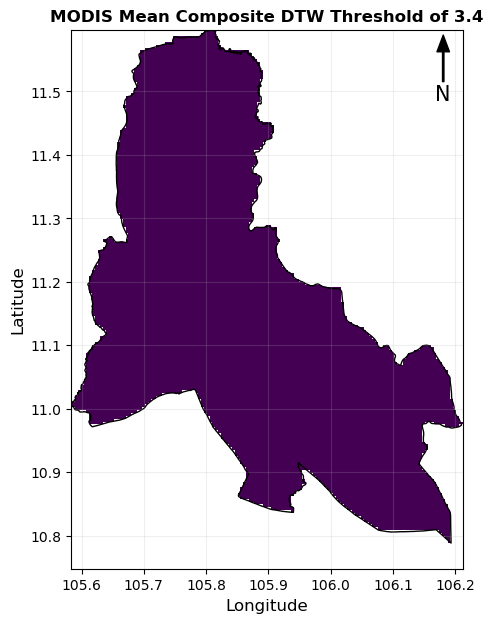

In [70]:
# perform DTW distance and obtain raster of DTW value
DTW_raster_MODIS = DTW_raster(stacked_NDVI_MODIS, reference_MODIS_NDVI_timeseries)

# threshold the DTW raster with of less than or equal to 3.4
thresholded_DTW_raster_MODIS = DTW_raster_MODIS.copy()
thresholded_DTW_raster_MODIS = (thresholded_DTW_raster_MODIS <= 3.4).astype(np.float64)
thresholded_DTW_raster_MODIS[thresholded_DTW_raster_MODIS == 0] = np.nan

# plot the result of DTW 
fig, ax = plt.subplots(figsize = (7,7))
show(thresholded_DTW_raster_MODIS, ax = ax, transform=MODIS_meanComposite_profile['transform'], 
     title = 'MODIS Mean Composite DTW Threshold of 3.4')

# aesthetics
ax.set_xlabel('Longitude', fontsize = 12)
ax.set_ylabel('Latitude', fontsize = 12)

# add arrow
x, y, arrow_length = 0.95, 0.99, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# add grid line
ax.grid(alpha = 0.2)

# add Svay Rieng Boundary 
study_boundary.plot(ax = ax, edgecolor = 'k', facecolor = 'none')


max DTW distance: 2.360528426545822
mean DTW distance: 0.33019894870346495
min DTW distance: 0.12171610120797675


''

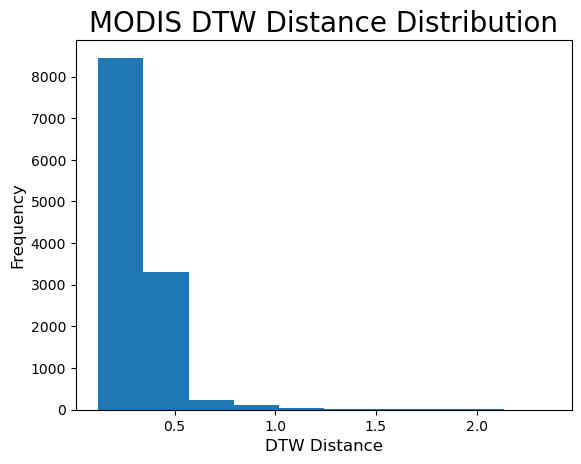

In [128]:
## view the statistics timeseries

DTW_value = DTW_raster_MODIS.flatten().copy()
DTW_value = DTW_value[~np.isnan(DTW_value)]

print('max DTW distance:', np.max(DTW_value))
print('mean DTW distance:', np.mean(DTW_value))
print('min DTW distance:', np.min(DTW_value))

plt.plot(figsize = (7,7))
plt.hist(DTW_value)
plt.xlabel('DTW Distance', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('MODIS DTW Distance Distribution', fontsize = 20)

;

C:\Users\varoc\AppData\Local\Temp\ipykernel_3456\941643253.py:8: RuntimeWarning: Mean of empty slice
  MODIS_NDVI_mean_raster = np.nanmean(stacked_NDVI_MODIS, axis= 0)


''

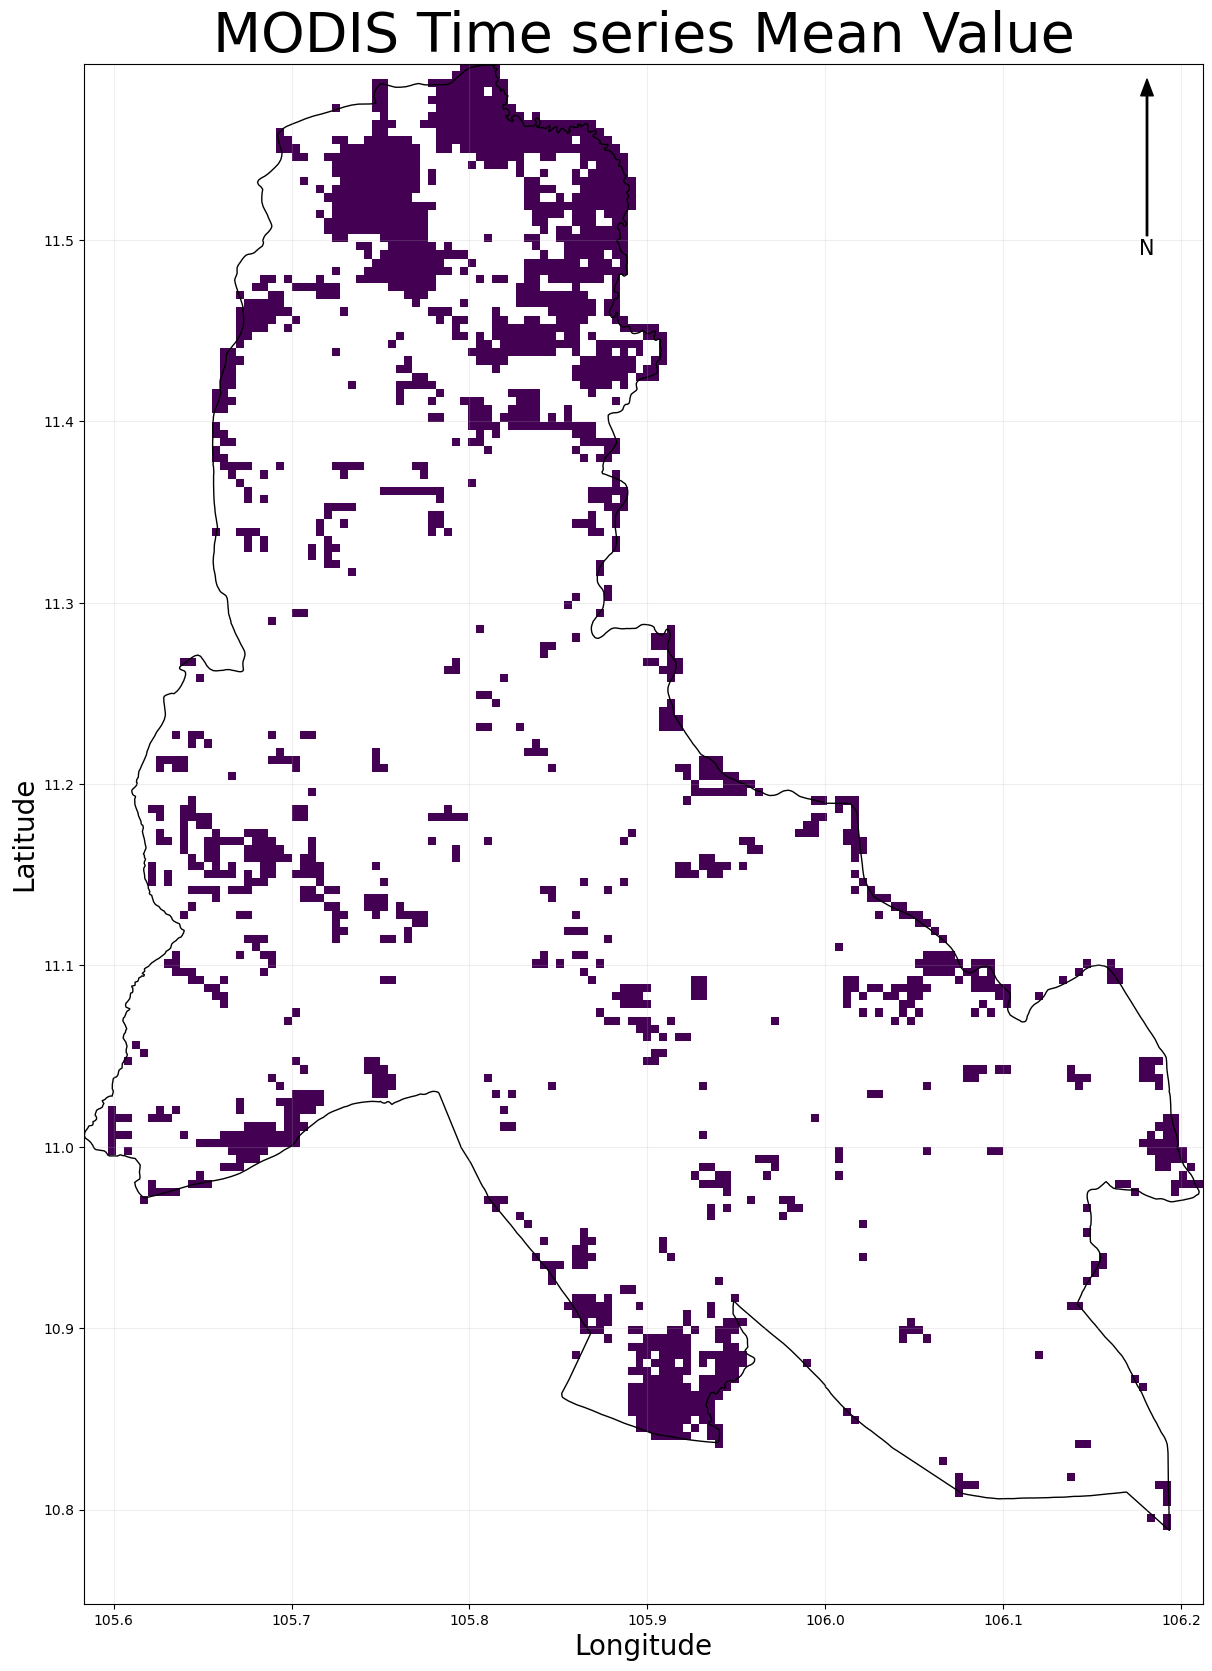

In [111]:
### instead of using DTW distance by comparing unknown to the reference_MODIS_NDVI_timeseries.
### we will aggregate them into mean and use the mean to conduct threshold

# aggregate reference timeseries into mean value
MODIS_avg_ref = np.mean(reference_MODIS_NDVI_timeseries)

# agregate the timeseries rraster into single band of mean values 
MODIS_NDVI_mean_raster = np.nanmean(stacked_NDVI_MODIS, axis= 0)

# conduct threholding
thresholded_MODIS_NDVI_mean_raster = MODIS_NDVI_mean_raster.copy()
thresholded_MODIS_NDVI_mean_raster = (thresholded_MODIS_NDVI_mean_raster >= MODIS_avg_ref).astype(np.float64)
thresholded_MODIS_NDVI_mean_raster[thresholded_MODIS_NDVI_mean_raster == 0] = np.nan

# plot the result of average NDVI values

fig, ax = plt.subplots(figsize = (20,20))
show(thresholded_MODIS_NDVI_mean_raster, ax = ax, transform=MODIS_meanComposite_profile['transform'])

# aesthetics
ax.set_title('MODIS Time series Mean Value', fontsize = 40)
ax.set_xlabel('Longitude', fontsize = 20)
ax.set_ylabel('Latitude', fontsize = 20)

# add arrow
x, y, arrow_length = 0.95, 0.99, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# add grid line
ax.grid(alpha = 0.2)

# add Svay Rieng Boundary 
study_boundary.plot(ax = ax, edgecolor = 'k', facecolor = 'none')
;

-------------------------------------------------------------------------------

-------------------------------------------------------------------------

------------------------------------------------------------------------------------

# Landsat 8: Load images and process data

### L8 Max Composite NDVI threshold
- visualize max NDVI composite and max reflectance composite. 
- vary threshold of 0.45, 0.5, 0.55, 0.6, 0.65

In [51]:
### read max composite L8 images 

# max reflectance composite
with rasterio.open('Landsat 8 Max Composite Jan-Mar\L8 Max Reflectance Composite-2017-01-01--2017-03-31.tif') as img:
    # read DN data
    Red_band = img.read(4).astype('float32') 
    NIR_band = img.read(5).astype('float32') 
    
    # process no data value
    Red_band[Red_band == img.nodata] = np.nan
    NIR_band[NIR_band == img.nodata] = np.nan

    # convert DN data into reflectance data
    Red_band = Red_band * 0.0000275 - 0.2
    NIR_band = NIR_band * 0.0000275 - 0.2	

    # calculate NDVI
    reflectance_composite_NDVI = (NIR_band - Red_band)/ (NIR_band + Red_band)

    # store max reflectance profile and metadata
    reflectance_composite_profile = img.profile
    reflectance_composite_profile['nodata'] = np.nan
    reflectance_composite_meta = img.meta
    reflectance_composite_meta['nodata'] = np.nan
    
# max NDVI composite
with rasterio.open('Landsat 8 Max Composite Jan-Mar\L8 Max NDVI Composite-2017-01-01--2017-03-31.tif') as img:
    # read NDVI composite NDVI data
    NDVI_composite_NDVI = img.read(1).astype('float32') 
    
    # process no data value
    NDVI_composite_NDVI[NDVI_composite_NDVI == img.nodata] = np.nan

    # store NDVI composite profile and metadata
    NDVI_composite_profile = img.profile
    NDVI_composite_meta = img.meta

In [52]:
# count the total number of pixels in the two provinces (exclude the white space nan)
L8_2pro_total_pixel = np.count_nonzero(~np.isnan(NDVI_composite_NDVI))

In [53]:
### specify L8 threshold export condition
L8_threshold_export = False

In [54]:
### conduct thresholding selection

threshold_list = [0.1, 0.2, 0.45, 0.5, 0.55, 0.6, 0.65]
reflectance_composite_NDVI_dict = {}
NDVI_composite_NDVI_dict  = {}

# iterate through threshold list
for threshold in threshold_list:
    # temporarily store NDVI values
    reflectance_NDVI = reflectance_composite_NDVI.copy()
    NDVI_NDVI = NDVI_composite_NDVI.copy()

    # conduct thresholding
    reflectance_NDVI[reflectance_NDVI < threshold] = reflectance_composite_meta['nodata']
    NDVI_NDVI[NDVI_NDVI < threshold] = NDVI_composite_meta['nodata']

    # store threshold
    reflectance_composite_NDVI_dict[f'{threshold}'] = reflectance_NDVI
    NDVI_composite_NDVI_dict[f'{threshold}'] = NDVI_NDVI

    ### export to tif
    if L8_threshold_export == True:
        # prepare output directory
        output_folder = 'Processed tif - Remote Sensing Project'
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        MODIS_reflectance_Comp_threshold_name = f'L8 Reflectance-{threshold} threshold NDVI.tif'
        MODIS_NDVI_Comp_threshold_name = f'L8 NDVI-{threshold} threshold NDVI.tif'

        # prepare TRUE and nan file for visual clarity
        reflectance_non_nan_pixel = np.where(~np.isnan(reflectance_composite_NDVI_dict[f'{threshold}']), True, np.nan)
        NDVI_non_nan_pixel = np.where(~np.isnan(NDVI_composite_NDVI_dict[f'{threshold}']), True, np.nan)

        # update output tif data
        NDVI_composite_profile['nodata'] = np.nan
        NDVI_composite_profile['dtype'] = NDVI_non_nan_pixel.dtype

        # export reflectance composite tif
        with rasterio.open(os.path.join(output_folder, MODIS_reflectance_Comp_threshold_name), 'w', **NDVI_composite_profile) as dst:
            dst.write(reflectance_non_nan_pixel, 1)
        # export NDVI composite tif
        with rasterio.open(os.path.join(output_folder, MODIS_NDVI_Comp_threshold_name), 'w', **NDVI_composite_profile) as dst:
            dst.write(NDVI_non_nan_pixel, 1)

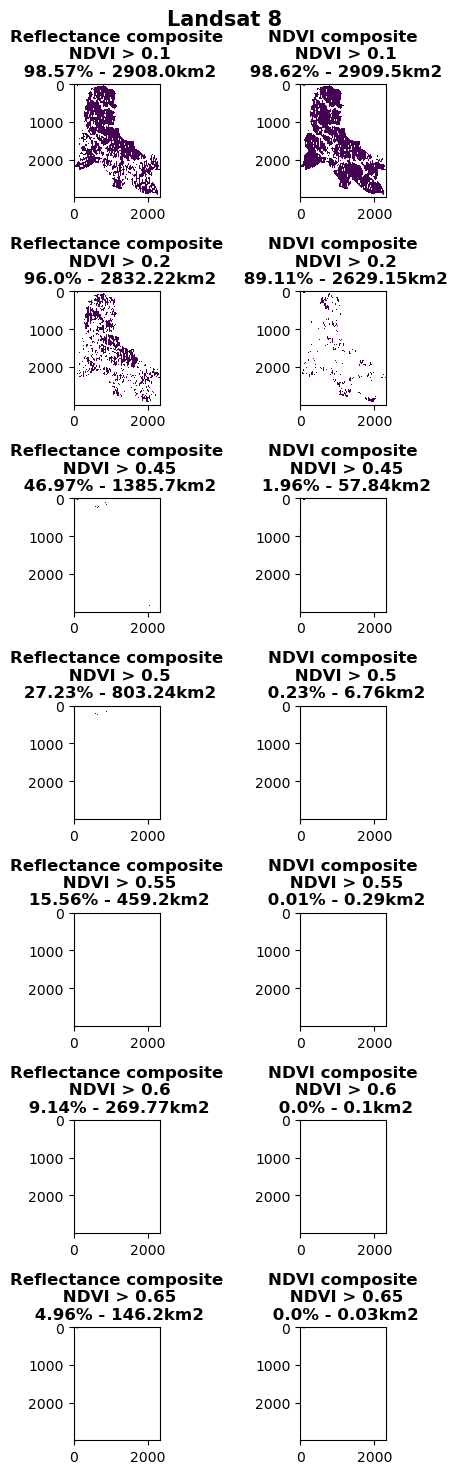

In [55]:
### plot thresholds

fig, ax = plt.subplots(len(threshold_list), 2 , figsize = (5, 15))

# iterate through threshold
for index, threshold in enumerate(threshold_list):
    
    ### plot for reflectance composite as True and nan (plot NDVI value blends in with background)
    # count non nan pixel and turn it into percent
    count_non_nan = np.count_nonzero(~np.isnan(reflectance_composite_NDVI_dict[f'{threshold}']))
    percent_pixel = round((count_non_nan/L8_2pro_total_pixel*100), 2)
    agri_area = (count_non_nan*30*30)/1000000
    # turn non nan pixel into True false
    reflectance_non_nan_pixel = np.where(~np.isnan(reflectance_composite_NDVI_dict[f'{threshold}']), True, np.nan)
    # plot map
    show(reflectance_non_nan_pixel, ax = ax[index, 0], 
         title= f'Reflectance composite\n NDVI > {threshold}\n {percent_pixel}% - {round(agri_area, 2)}km2')

    ### plot for NDVI composite as True and nan (plot NDVI value blends in with background)
    # count non nan pixel and turn it into percent
    count_non_nan = np.count_nonzero(~np.isnan(NDVI_composite_NDVI_dict[f'{threshold}']))
    percent_pixel = round((count_non_nan/L8_2pro_total_pixel*100), 2)
    agri_area = (count_non_nan*30*30)/1000000
    # turn non nan pixel into True false
    NDVI_non_nan_pixel = np.where(~np.isnan(NDVI_composite_NDVI_dict[f'{threshold}']), True, np.nan)

    # plot map
    show(NDVI_non_nan_pixel, ax = ax[index, 1], 
         title= f'NDVI composite\n NDVI > {threshold}\n {percent_pixel}% - {round(agri_area, 2)}km2')
    
    # add study boundary
    study_boundary.plot(ax=ax[index, 0], edgecolor = 'k', facecolor = 'none')
    study_boundary.plot(ax=ax[index, 1], edgecolor = 'k', facecolor = 'none')
     
plt.suptitle('Landsat 8', fontsize = 15, weight = 'bold')

plt.tight_layout()

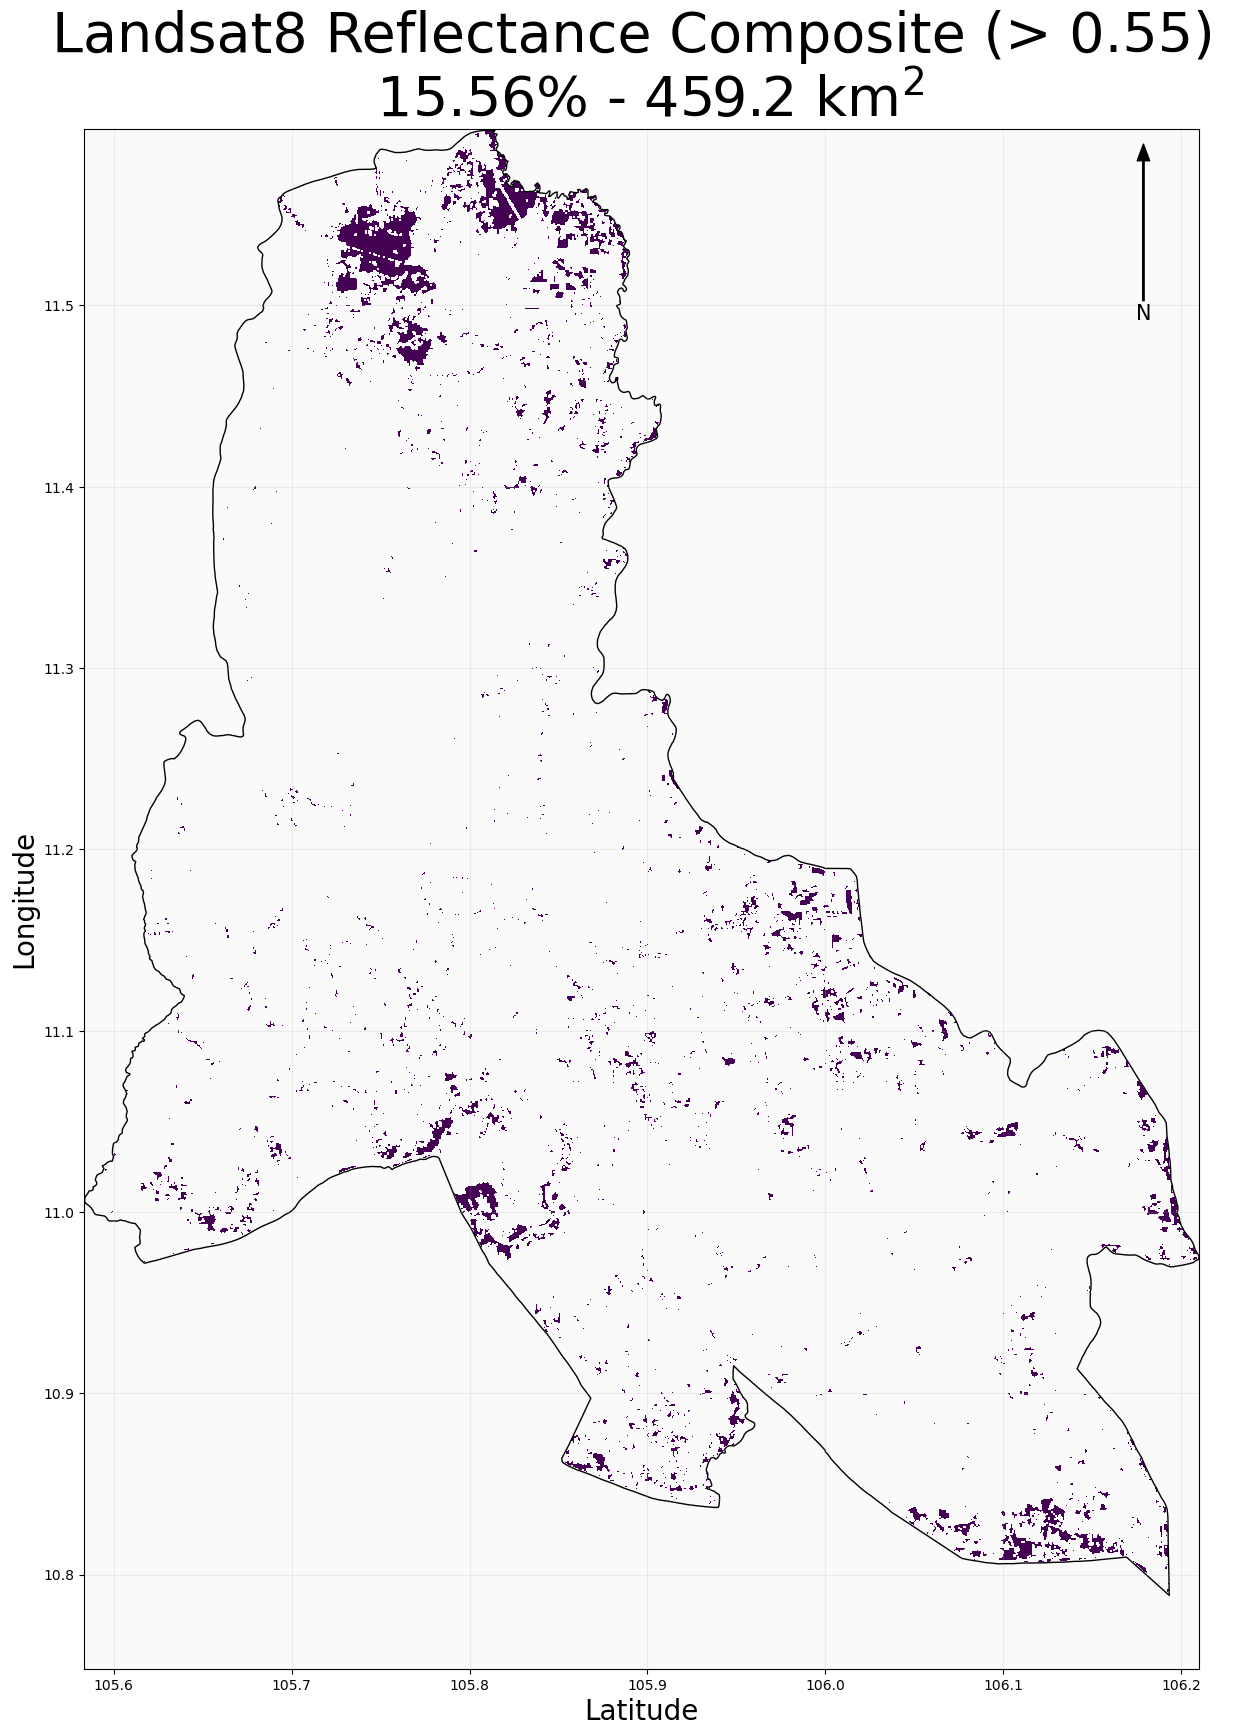

In [113]:
### plot Reflectance Composite 0.55

L8_file = 'Processed tif - Remote Sensing Project\L8 Reflectance-0.55 threshold NDVI.tif'
fig, ax = plt.subplots(figsize=(20, 20))

with rasterio.open(L8_file) as L8_visual:
    show(L8_visual, ax = ax)

    L8_visual_raster = L8_visual.read(1)
    count_non_nan = np.count_nonzero(~np.isnan(L8_visual_raster))
    percent_pixel = round((count_non_nan/L8_2pro_total_pixel*100), 2)
    agri_area = (count_non_nan*30*30)/1000000


# aesthetics
ax.set_title(f'Landsat8 Reflectance Composite (> 0.55) \n {percent_pixel}% - {round(agri_area, 2)} km$^2$', 
                fontsize = 40)
ax.set_xlabel('Latitude', fontsize = 20)
ax.set_ylabel('Longitude', fontsize = 20)

# add arrow
x, y, arrow_length = 0.95, 0.99, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# add grid line
ax.grid(alpha = 0.2)

# add Svay Rieng Boundary 
study_boundary.plot(ax = ax, edgecolor = 'k', facecolor = 'none')


# Set the background color with alpha (transparency)
background_color = 'lightgray'  # You can change 'lightgray' to any color you prefer
alpha = 0.1  # You can adjust the alpha value as needed

ax.set_facecolor(background_color)
ax.patch.set_alpha(alpha)

----------------------------------------------------------------------------

### L8 DTW-distance time series classifications

this is a little different from MODIS in that we have to extrapolate and/or interpolate at the reflectance level before calculating NDVI

In [18]:
### extract coordinate from shapefile

# open raster
sample_raster = 'Landsat 8 2016-2017 Dry Season Monthly Mean Composite\L8 Composite-2016-11-01--2016-11-30.tif'
with rasterio.open(sample_raster) as img:
    # get MODIS reference shapefile
    L8_ref_gdf = gpd.read_file('Reference Raster\L8 Agricultural Polygon.shp')

    # initialize variable to store MODIS pixel corresponding to shape file
    combined_mask = np.zeros(img.shape, dtype=bool)
    # iterate through every polygon in shape file and store cooresponding MODIS pixel mask in combined_mask
    for index, row in L8_ref_gdf.iterrows():
        geom = row['geometry']
        mask = geometry_mask([geom], out_shape=img.shape, transform=img.transform, all_touched= True, invert=True)
        combined_mask |= mask

    # get profile for later plots
    L8_meanComposite_profile = img.profile

# turn False values into nan and True value into 1
combined_mask = combined_mask.astype(float)  # Convert the mask to a float type
combined_mask[combined_mask == 0] = np.nan

<Axes: title={'center': 'Landsat8 Reference Pixels: 64649.0 pixels'}, xlabel='Longitude', ylabel='Latitude'>

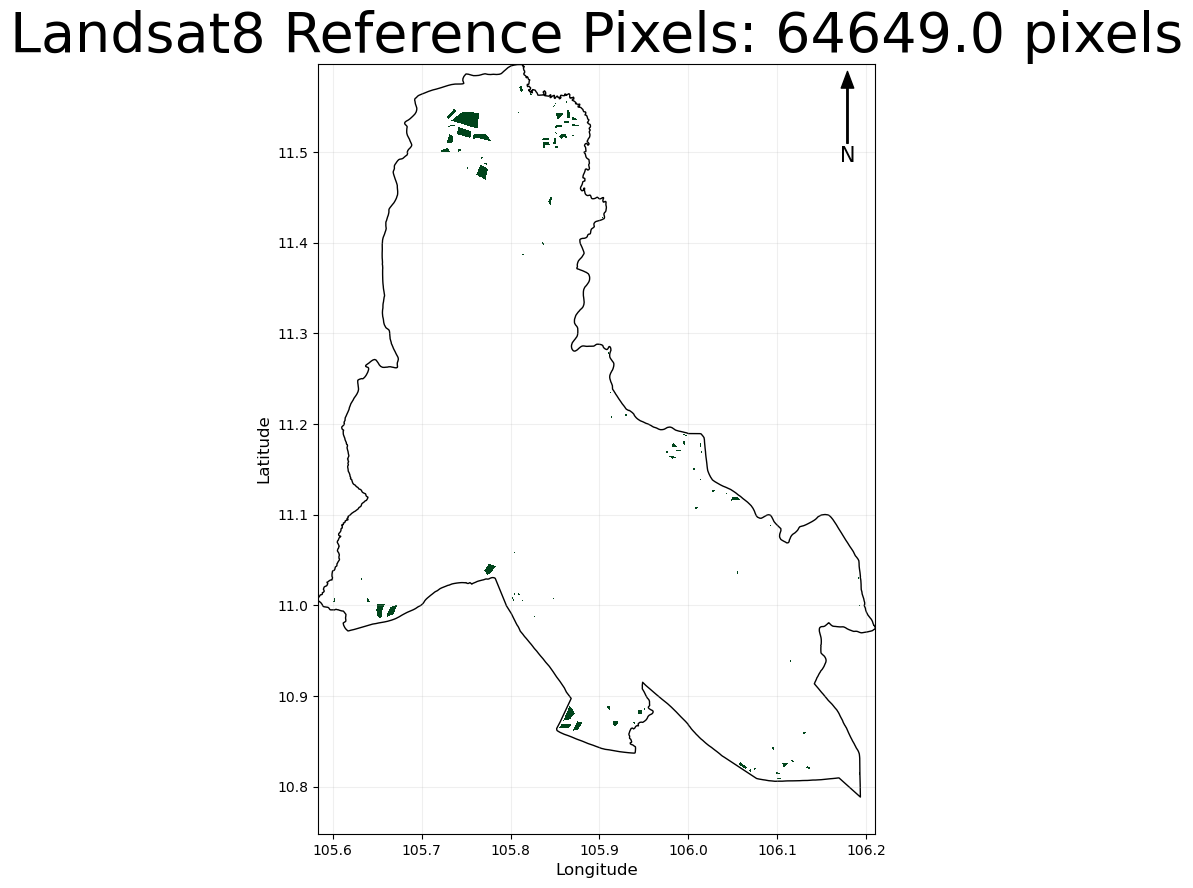

In [19]:
### plot MODIS reference pixel
fig, ax = plt.subplots(figsize = (10,10))
show(combined_mask, ax = ax, transform=L8_meanComposite_profile['transform'], cmap = 'Greens_r')

# aesthetics
ax.set_xlabel('Longitude', fontsize = 12)
ax.set_ylabel('Latitude', fontsize = 12)
ax.set_title( f'Landsat8 Reference Pixels: {np.nansum(combined_mask)} pixels', fontsize = 40)
# add arrow
x, y, arrow_length = 0.95, 0.99, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# add grid line
ax.grid(alpha = 0.2)

# add Svay Rieng Boundary 
study_boundary.plot(ax = ax, edgecolor = 'k', facecolor = 'none')

In [61]:
# prepare to read images

folder = 'Landsat 8 2016-2017 Dry Season Monthly Mean Composite'
filenames = [file for file in os.listdir(folder) if file.endswith('.tif')]

image_data_list = []

# iterate through every images in the study period
for filename in filenames:    
    # read image file
    path = os.path.join(folder, filename)
    with rasterio.open(path) as img:
        
        # calculate NDVI 
        NDVI_raster = NDVI_calculation(img, "Landsat 8")

        # store NDVI value in list
        image_data_list.append(NDVI_raster)

        # get profile
        L8_meanComposite_profile = img.profile

# stack the NDVI values to create [time, row, column] 3D array
stacked_NDVI_L8 = np.stack(image_data_list, axis = 0)

# fill in the spot left by cloud cover and perform SG filter
for row in np.arange(stacked_NDVI_L8.shape[1]):
    for col in np.arange(stacked_NDVI_L8.shape[2]):
        current_pixel_timeseries = stacked_NDVI_L8[:, row, col]
        
        if np.any(~np.isnan(current_pixel_timeseries)):

            # interpolate and extrapolate from known values
            current_pixel_timeseries = interpolate_and_extrapolate(current_pixel_timeseries)

            # perform SG filter
            current_pixel_timeseries = signal.savgol_filter(current_pixel_timeseries, window_length=4, polyorder=3, mode="nearest")

            # replace timeseries value
            stacked_NDVI_L8[:, row, col] = current_pixel_timeseries

# perform DTW distance and obtain raster of DTW value
# DTW_raster_L8 = DTW_raster(stacked_NDVI_L8, L8_ref)


KeyboardInterrupt: 

In [59]:
### get reference timeseries 

# duplicate "one time" combined_mask stack to match the "time" of the stacked_NDVI_MODIS 
stacked_combined_mask = np.tile(combined_mask, (stacked_NDVI_L8.shape[0], 1, 1))

# select only reference pixel
stacked_reference_L8_timeseries = stacked_combined_mask * stacked_NDVI_L8

# get reference NDVI timeseries
reference_L8_NDVI_timeseries = np.nanmean(stacked_reference_L8_timeseries, axis=(1,2))

In [ ]:
# perform DTW distance and obtain raster of DTW value
DTW_raster_L8 = DTW_raster(stacked_NDVI_L8, reference_L8_NDVI_timeseries)

<Axes: title={'center': 'Landsat 8 Mean Composite DTW Threshold of 3.4'}, xlabel='Longitude', ylabel='Latitude'>

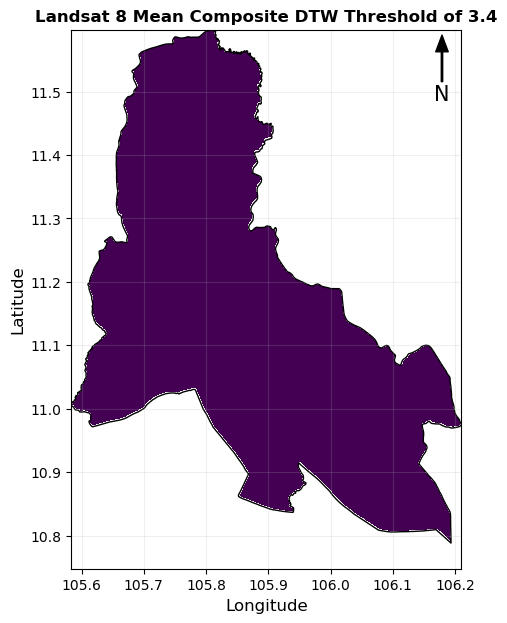

In [71]:

# threshold the DTW raster with of less than or equal to 3.4
thresholded_DTW_raster_L8 = DTW_raster_L8.copy()
thresholded_DTW_raster_L8 = (thresholded_DTW_raster_L8 <= 3.4).astype(np.float64)
thresholded_DTW_raster_L8[thresholded_DTW_raster_L8 == 0] = np.nan

# plot the result of DTW 
fig, ax = plt.subplots(figsize = (7,7))
show(thresholded_DTW_raster_L8, ax = ax, transform = L8_meanComposite_profile['transform'],
     title = 'Landsat 8 Mean Composite DTW Threshold of 3.4')

# aesthetics
ax.set_xlabel('Longitude', fontsize = 12)
ax.set_ylabel('Latitude', fontsize = 12)

# add arrow
x, y, arrow_length = 0.95, 0.99, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# add grid line
ax.grid(alpha = 0.2)


# add Svay Rieng Boundary 
study_boundary.plot(ax = ax, edgecolor = 'k', facecolor = 'none')



max DTW distance: 1.481214806121999
mean DTW distance: 0.23032621845106793
min DTW distance: 0.009512717730076175


''

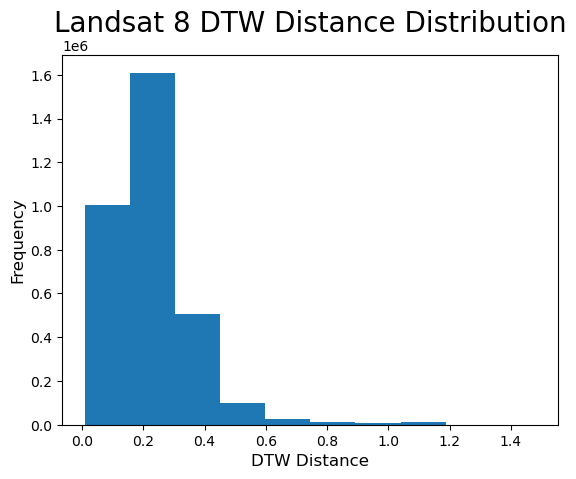

In [127]:
## view the statistics timeseries

DTW_value_L8 = DTW_raster_L8.flatten().copy()
DTW_value_L8 = DTW_value_L8[~np.isnan(DTW_value_L8)]

print('max DTW distance:', np.max(DTW_value_L8))
print('mean DTW distance:', np.mean(DTW_value_L8))
print('min DTW distance:', np.min(DTW_value_L8))

plt.plot(figsize = (7,7))
plt.hist(DTW_value_L8)
plt.xlabel('DTW Distance', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Landsat 8 DTW Distance Distribution', fontsize = 20)

;

C:\Users\varoc\AppData\Local\Temp\ipykernel_3456\456577879.py:8: RuntimeWarning: Mean of empty slice
  L8_NDVI_mean_raster = np.nanmean(stacked_NDVI_L8, axis= 0)


''

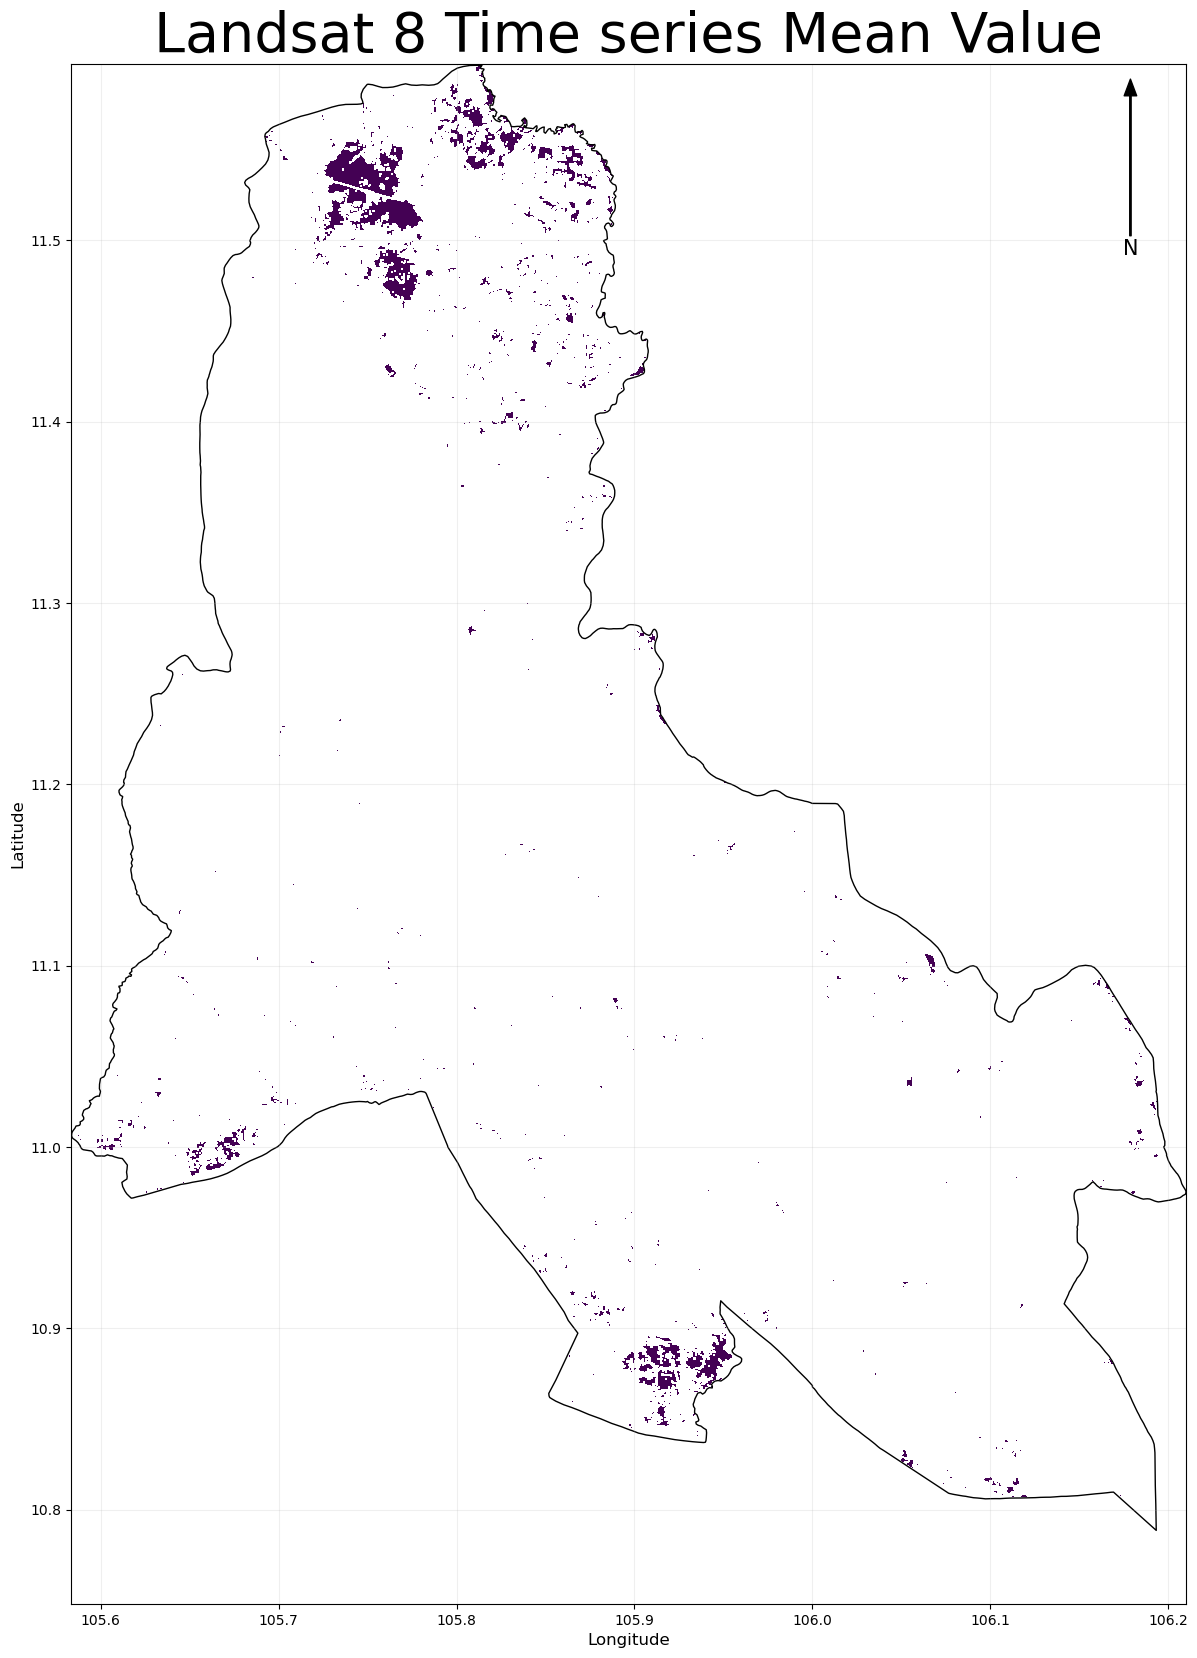

In [112]:
### instead of using DTW distance by comparing unknown to the reference_MODIS_NDVI_timeseries.
### we will aggregate them into mean and use the mean to conduct threshold

# aggregate reference timeseries into mean value
L8_avg_ref = np.mean(reference_L8_NDVI_timeseries)

# agregate the timeseries rraster into single band of mean values 
L8_NDVI_mean_raster = np.nanmean(stacked_NDVI_L8, axis= 0)

# conduct threholding
thresholded_L8_NDVI_mean_raster = L8_NDVI_mean_raster.copy()
thresholded_L8_NDVI_mean_raster = (thresholded_L8_NDVI_mean_raster >= L8_avg_ref).astype(np.float64)
thresholded_L8_NDVI_mean_raster[thresholded_L8_NDVI_mean_raster == 0] = np.nan

# plot the result of average NDVI values

fig, ax = plt.subplots(figsize = (20,20))
show(thresholded_L8_NDVI_mean_raster, ax = ax, transform= L8_meanComposite_profile['transform'])
# aesthetics
ax.set_title('Landsat 8 Time series Mean Value', fontsize = 40)
ax.set_xlabel('Longitude', fontsize = 12)
ax.set_ylabel('Latitude', fontsize = 12)

# add arrow
x, y, arrow_length = 0.95, 0.99, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# add grid line
ax.grid(alpha = 0.2)

# add Svay Rieng Boundary 
study_boundary.plot(ax = ax, edgecolor = 'k', facecolor = 'none')
;

------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------

# Compare with LULC Map

In [130]:
### print the agricultural area
print('MODIS DTW',  np.nansum(thresholded_DTW_raster_MODIS) * 500 * 500 / 1000000 ,' \n')
print("MODIS Mean timeseries", np.nansum(thresholded_MODIS_NDVI_mean_raster) * 500 * 500 / 1000000 ,' \n')
print(round((np.nansum(thresholded_MODIS_NDVI_mean_raster)/MODIS_2pro_total_pixel*100), 2), '\n')
print('L8 DTW:', np.nansum(thresholded_DTW_raster_L8) * 30 * 30 / 1000000,' \n')
print(round((np.nansum(thresholded_L8_NDVI_mean_raster)/L8_2pro_total_pixel*100), 2), '\n')
print("L8 Mean timeseries", np.nansum(thresholded_L8_NDVI_mean_raster)* 30 * 30 / 1000000)

MODIS DTW 3040.5  

MODIS Mean timeseries 467.75  

15.38 

L8 DTW: 2950.3098  

7.39 

L8 Mean timeseries 218.0835


In [73]:
from rasterio.mask import mask

In [74]:
### extract total number of pixels and crops pixel 

LULC_path = 'LULC SR map reference\SR RS DynamicWorld-2016-12-01--2017-03-01.tif'
with rasterio.open(LULC_path) as LULC_img:
    # obtain LULC raster
    Lulc_profile = LULC_img.profile
    Lulc_profile['nodata'] = np.nan
    Lulc_profile['dtype'] = np.float64
    
    LULC_raster = LULC_img.read(1).astype('float64')
    LULC_raster[LULC_raster == LULC_img] = np.nan
    

    # mask all pixels except crops
    crops_LULC_raster = LULC_raster.copy()
    crops_LULC_raster[crops_LULC_raster != 4] = np.nan
    
    # count non-nan pixels 
    crops_pixel_count = np.count_nonzero(~np.isnan(crops_LULC_raster))
    LULC_agri_area = crops_pixel_count*10*10/1000000


# export LULC crop
output_folder = 'Processed tif - Remote Sensing Project'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
LULC_outname = 'LULC crops.tif'
with rasterio.open(os.path.join(output_folder, LULC_outname), 'w', **Lulc_profile) as dst:
    dst.write(crops_LULC_raster, 1)


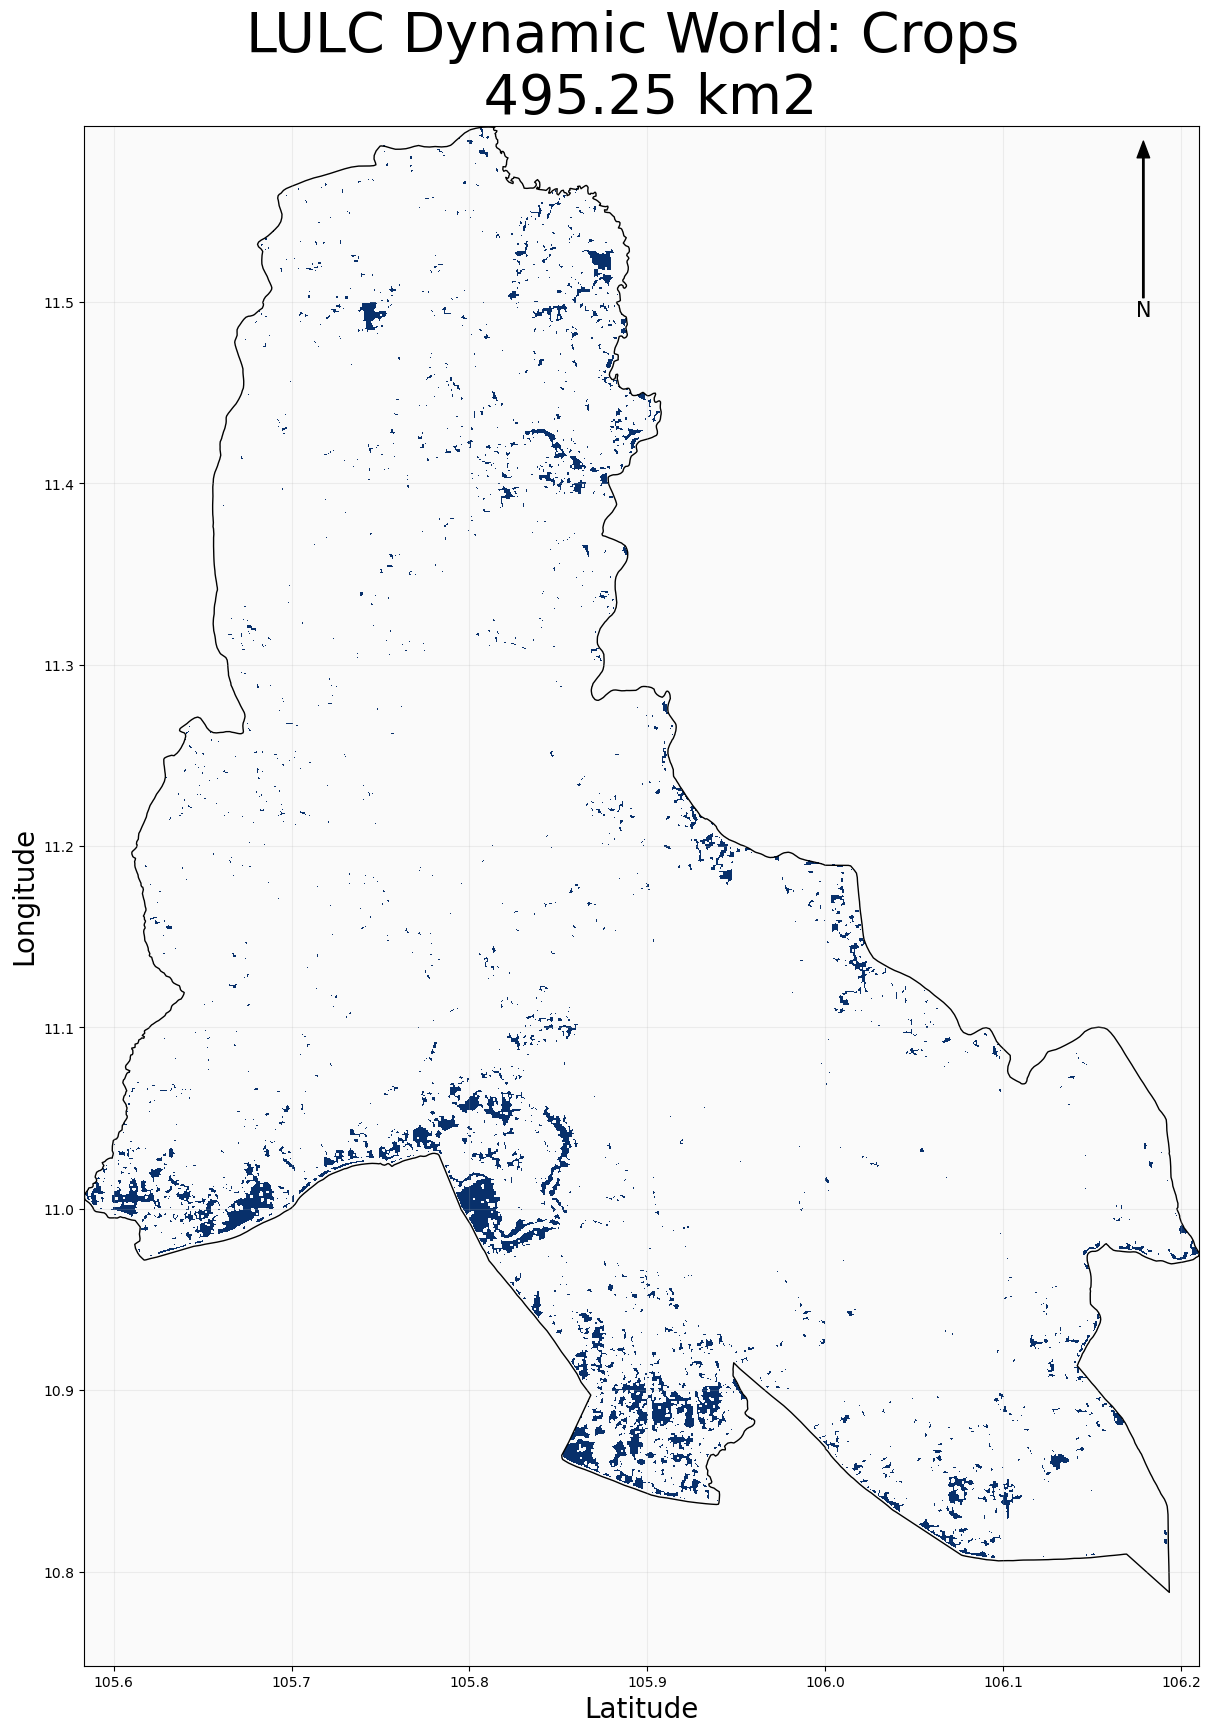

In [114]:
### plot LULC crop

Lulc_file = 'Processed tif - Remote Sensing Project\LULC crops.tif'

fig, ax = plt.subplots(figsize=(20, 20))

with rasterio.open(Lulc_file) as Lulc_visual:
    show(Lulc_visual, ax = ax, transform = Lulc_profile['transform'], cmap = 'Blues_r')

    Lulc_visual_raster = Lulc_visual.read(1)
    count_non_nan = np.count_nonzero(~np.isnan(Lulc_visual_raster))
    Lulc_agri_area = (count_non_nan*10*10)/1000000


# aesthetics
ax.set_title(f'LULC Dynamic World: Crops \n {round(Lulc_agri_area, 2)} km2', fontsize = 40)

ax.set_xlabel('Latitude', fontsize = 20)
ax.set_ylabel('Longitude', fontsize = 20)


# add arrow
x, y, arrow_length = 0.95, 0.99, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# add grid line
ax.grid(alpha = 0.2)

# add Svay Rieng Boundary 
study_boundary.plot(ax = ax, edgecolor = 'k', facecolor = 'none')

# Set the background color with alpha (transparency)
background_color = 'lightgray'  # You can change 'lightgray' to any color you prefer
alpha = 0.1  # You can adjust the alpha value as needed

ax.set_facecolor(background_color)
ax.patch.set_alpha(alpha)

Plot comparsion with the selected plot from MODIS and Landsat 8

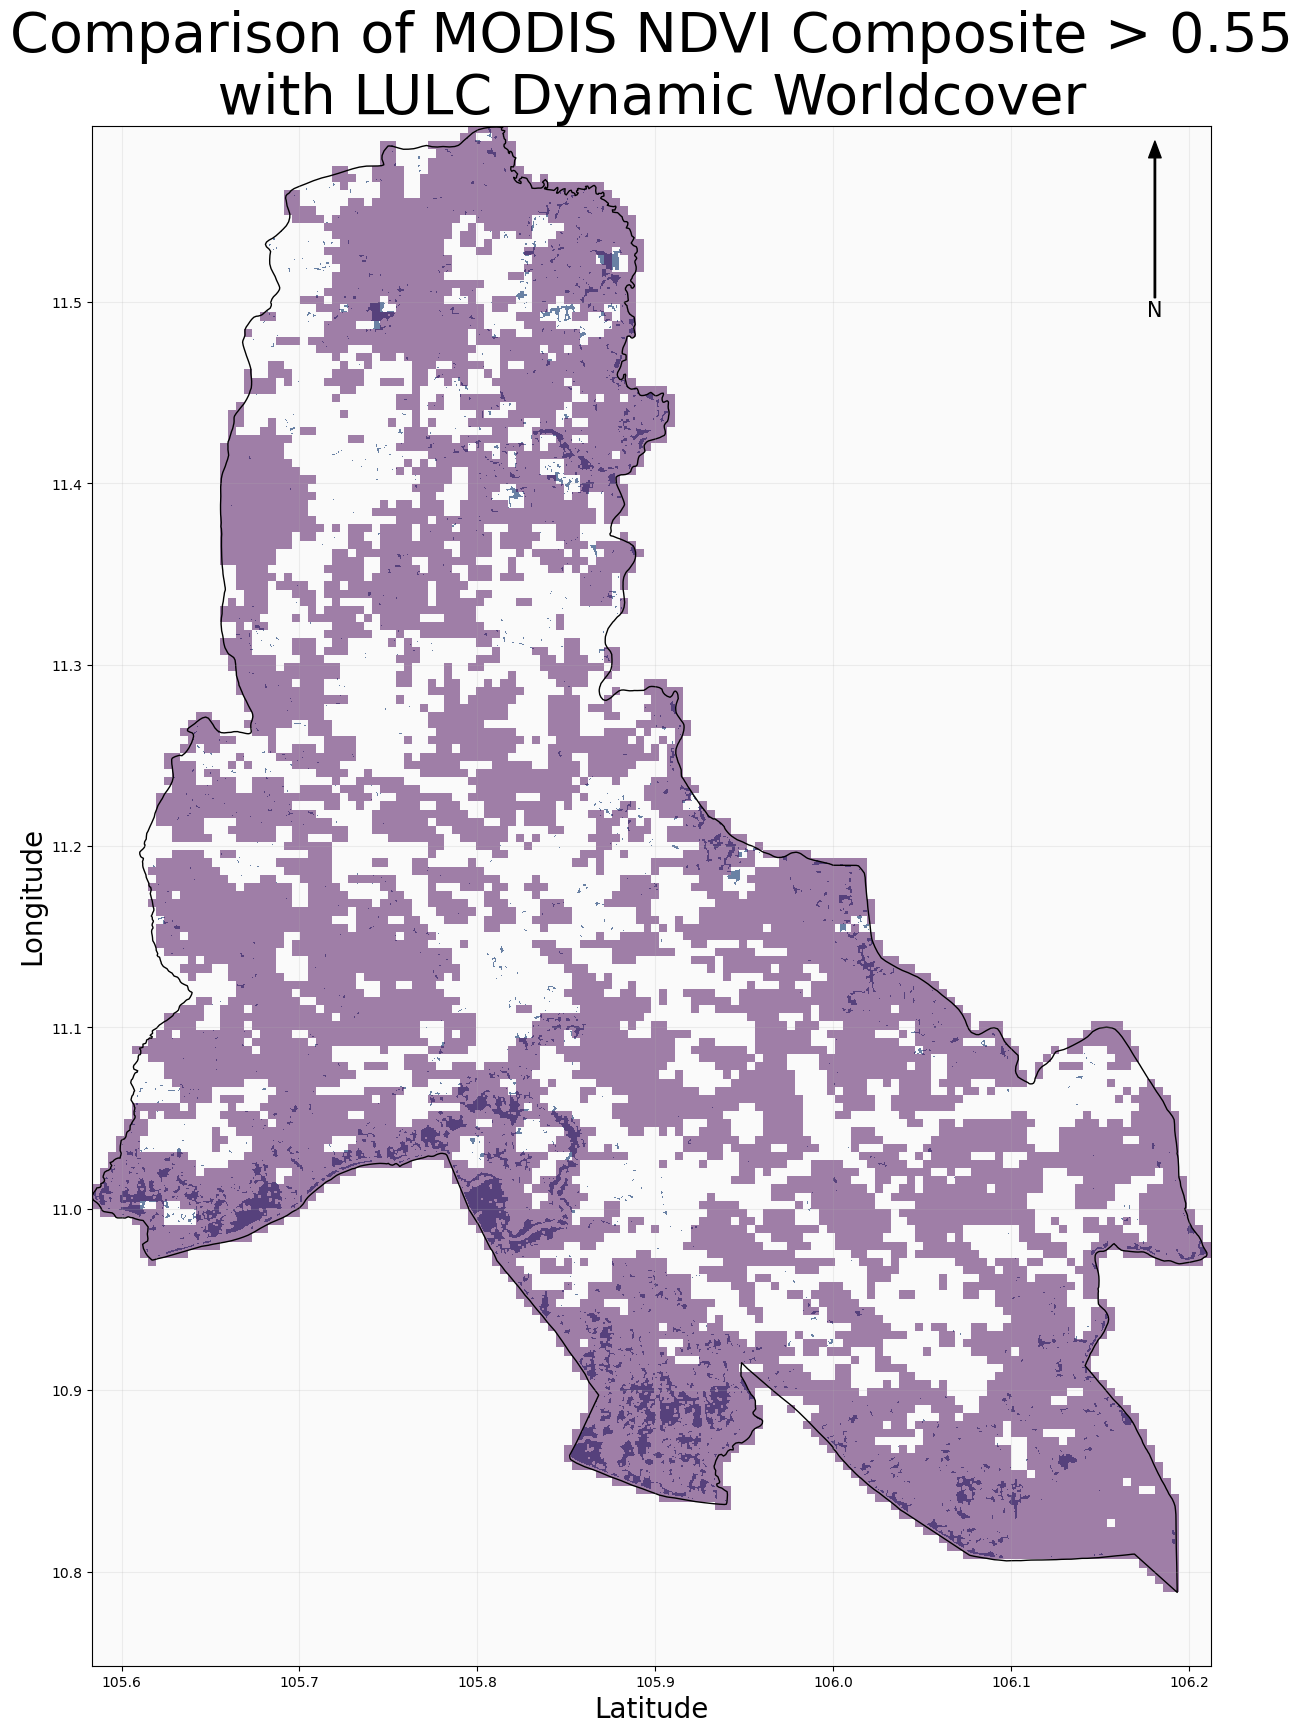

In [125]:
### Compare MODIS NDVI Composite 0.55 with LULC

Lulc_file = 'Processed tif - Remote Sensing Project\LULC crops.tif'

fig, ax = plt.subplots(figsize=(20, 20))

with rasterio.open(Lulc_file) as Lulc_visual:
    show(Lulc_visual, ax = ax, transform = Lulc_profile['transform'], cmap = 'Blues_r', alpha = 0.6)

with rasterio.open(MODIS_file) as MODIS_visual:
    show(MODIS_visual, ax = ax, transform = NDVI_composite_profile['transform'], alpha = 0.5)

# aesthetics
ax.set_title(f'Comparison of MODIS NDVI Composite > 0.55\n with LULC Dynamic Worldcover ', fontsize = 40)

ax.set_xlabel('Latitude', fontsize = 20)
ax.set_ylabel('Longitude', fontsize = 20)


# add arrow
x, y, arrow_length = 0.95, 0.99, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# add grid line
ax.grid(alpha = 0.2)

# add Svay Rieng Boundary 
study_boundary.plot(ax = ax, edgecolor = 'k', facecolor = 'none')

# Set the background color with alpha (transparency)
background_color = 'lightgray'  # You can change 'lightgray' to any color you prefer
alpha = 0.1  # You can adjust the alpha value as needed

ax.set_facecolor(background_color)
ax.patch.set_alpha(alpha)

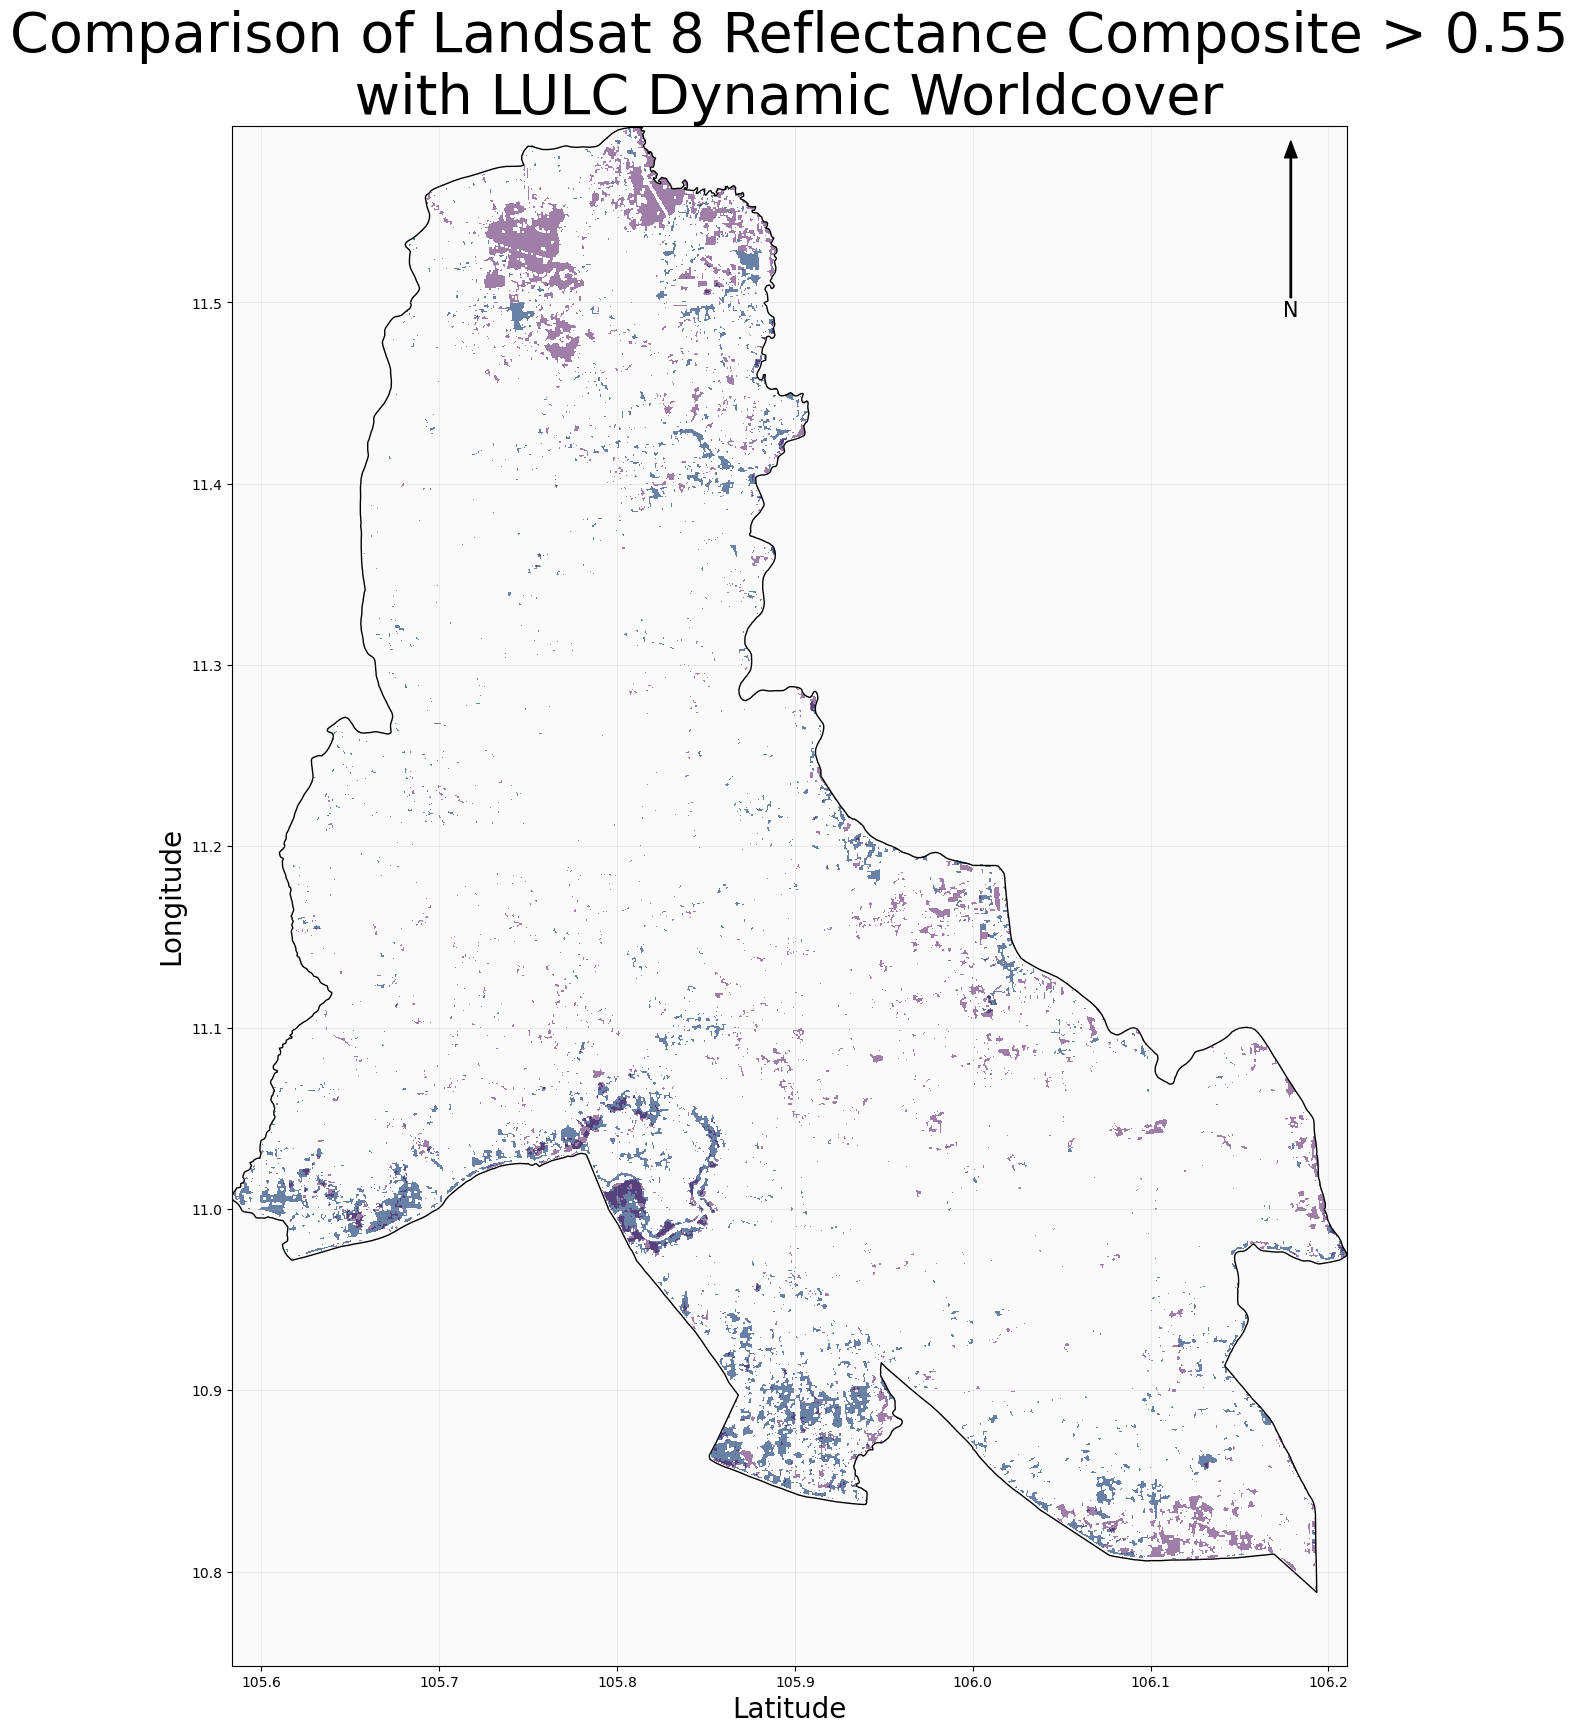

In [124]:
### Compare L8 Reflectance Composite 0.55 with LULC

Lulc_file = 'Processed tif - Remote Sensing Project\LULC crops.tif'

fig, ax = plt.subplots(figsize=(20, 20))

with rasterio.open(Lulc_file) as Lulc_visual:
    show(Lulc_visual, ax = ax, transform = Lulc_profile['transform'], cmap = 'Blues_r',
         alpha = 0.6)

with rasterio.open(L8_file) as L8_visual:
    show(L8_visual, ax = ax, alpha = 0.5)

# aesthetics
ax.set_title(f'Comparison of Landsat 8 Reflectance Composite > 0.55\n with LULC Dynamic Worldcover ', fontsize = 40)

ax.set_xlabel('Latitude', fontsize = 20)
ax.set_ylabel('Longitude', fontsize = 20)


# add arrow
x, y, arrow_length = 0.95, 0.99, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# add grid line
ax.grid(alpha = 0.2)

# add Svay Rieng Boundary 
study_boundary.plot(ax = ax, edgecolor = 'k', facecolor = 'none')

# Set the background color with alpha (transparency)
background_color = 'lightgray'  # You can change 'lightgray' to any color you prefer
alpha = 0.1  # You can adjust the alpha value as needed

ax.set_facecolor(background_color)
ax.patch.set_alpha(alpha)

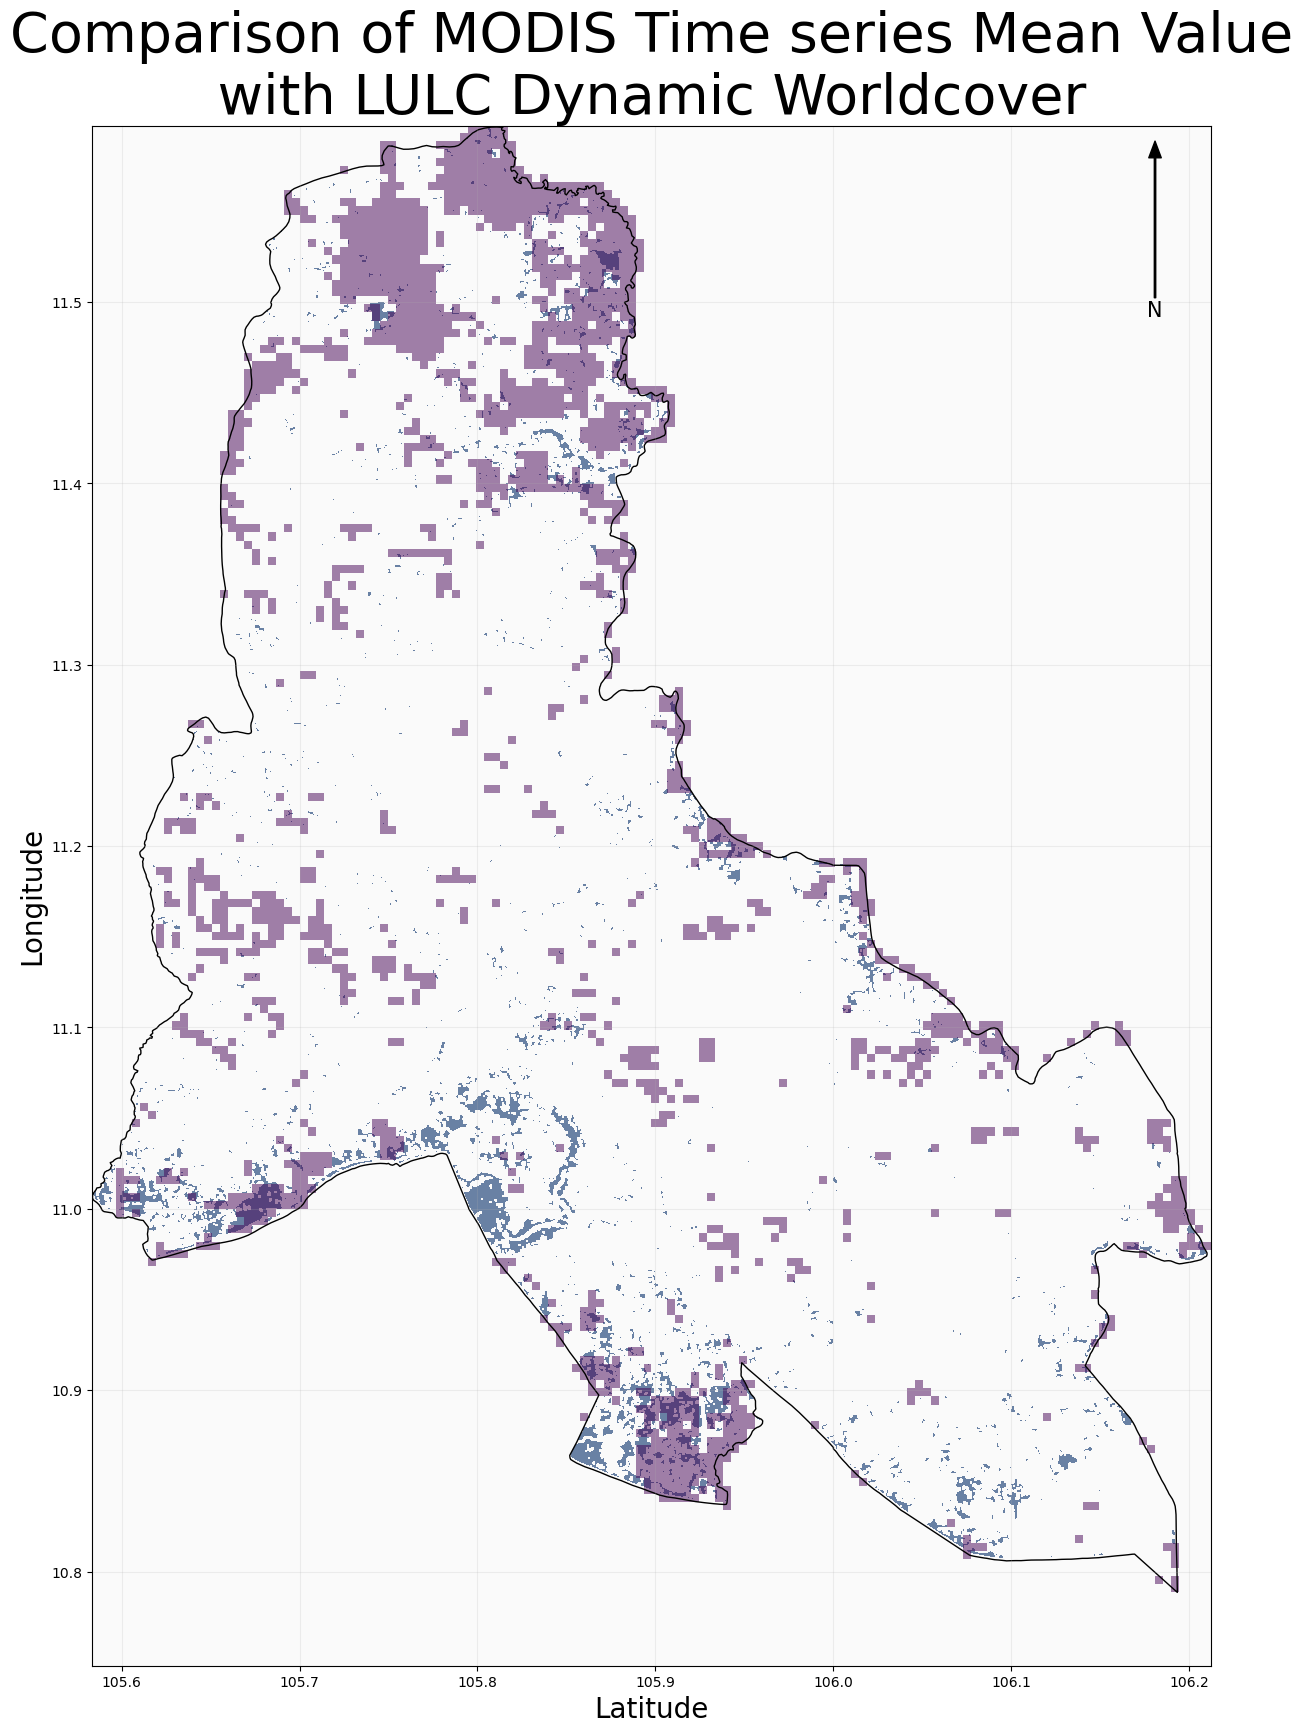

In [121]:
### Compare MODIS Mean Timeseries with LULC

Lulc_file = 'Processed tif - Remote Sensing Project\LULC crops.tif'

fig, ax = plt.subplots(figsize=(20, 20))

with rasterio.open(Lulc_file) as Lulc_visual:
    show(Lulc_visual, ax = ax, transform = Lulc_profile['transform'], cmap = 'Blues_r',
         alpha = 0.6)

show(thresholded_MODIS_NDVI_mean_raster, ax = ax, transform=MODIS_meanComposite_profile['transform'], 
     alpha = 0.5)

# aesthetics
ax.set_title(f'Comparison of MODIS Time series Mean Value\n with LULC Dynamic Worldcover ', fontsize = 40)

ax.set_xlabel('Latitude', fontsize = 20)
ax.set_ylabel('Longitude', fontsize = 20)


# add arrow
x, y, arrow_length = 0.95, 0.99, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# add grid line
ax.grid(alpha = 0.2)

# add Svay Rieng Boundary 
study_boundary.plot(ax = ax, edgecolor = 'k', facecolor = 'none')

# Set the background color with alpha (transparency)
background_color = 'lightgray'  # You can change 'lightgray' to any color you prefer
alpha = 0.1  # You can adjust the alpha value as needed

ax.set_facecolor(background_color)
ax.patch.set_alpha(alpha)

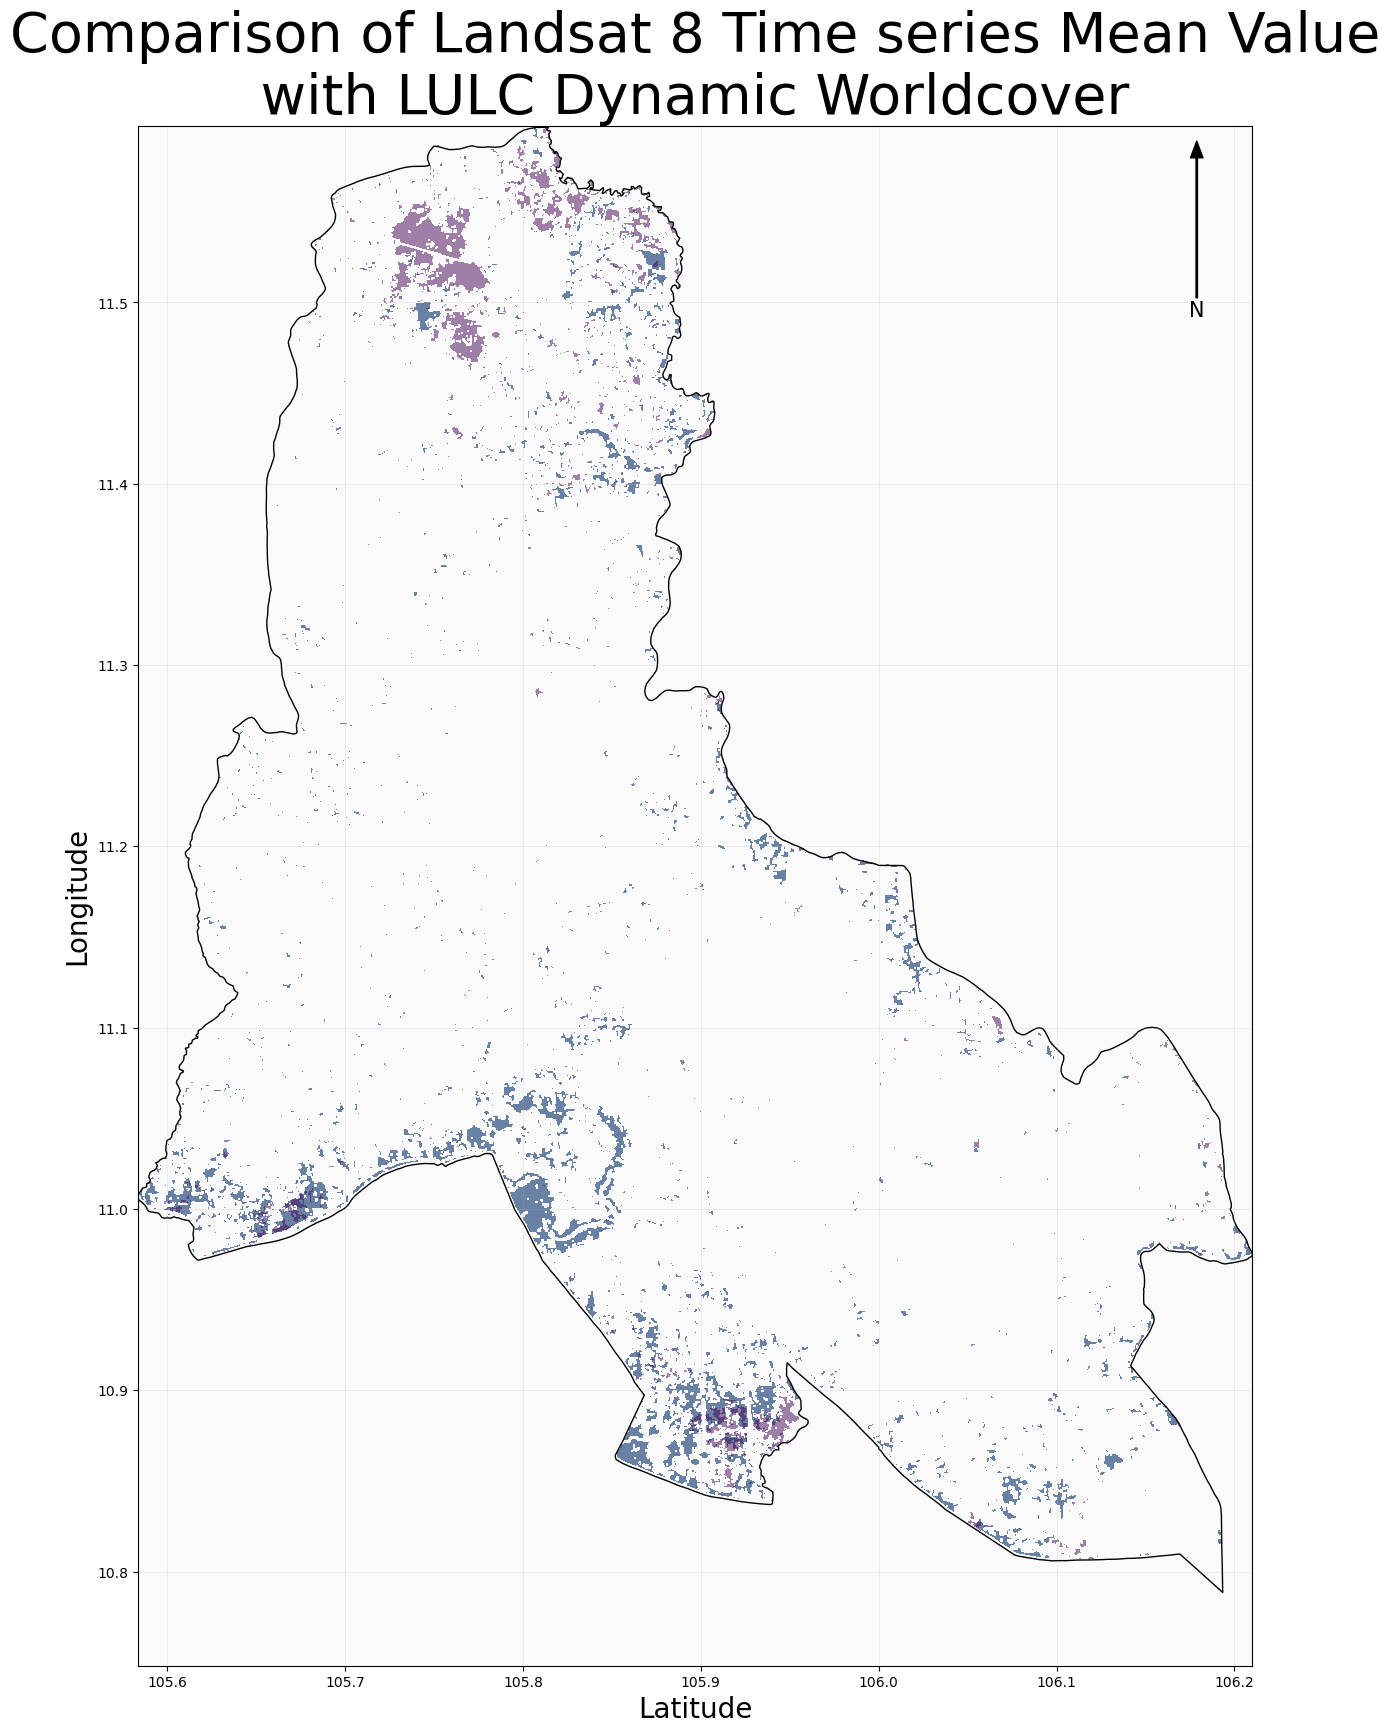

In [120]:
### Compare L8 Mean Timeseries with LULC

Lulc_file = 'Processed tif - Remote Sensing Project\LULC crops.tif'

fig, ax = plt.subplots(figsize=(20, 20))

with rasterio.open(Lulc_file) as Lulc_visual:
    show(Lulc_visual, ax = ax, transform = Lulc_profile['transform'], cmap = 'Blues_r', alpha = 0.6)

show(thresholded_L8_NDVI_mean_raster, ax = ax, transform= L8_meanComposite_profile['transform'],
     alpha = 0.5)

# aesthetics
ax.set_title(f'Comparison of Landsat 8 Time series Mean Value\n with LULC Dynamic Worldcover ', fontsize = 40)

ax.set_xlabel('Latitude', fontsize = 20)
ax.set_ylabel('Longitude', fontsize = 20)


# add arrow
x, y, arrow_length = 0.95, 0.99, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# add grid line
ax.grid(alpha = 0.2)

# add Svay Rieng Boundary 
study_boundary.plot(ax = ax, edgecolor = 'k', facecolor = 'none')

# Set the background color with alpha (transparency)
background_color = 'lightgray'  # You can change 'lightgray' to any color you prefer
alpha = 0.1  # You can adjust the alpha value as needed

ax.set_facecolor(background_color)
ax.patch.set_alpha(alpha)

# Test